# Название проекта: Коровы

**Цель проекта: На основе моделей машинного обучения предложить рекомендации по покупке коров**

**Описание проекта:**

Иморт библиотек

Загрузка данных, изучение общей информации

Предобработка данных.

* Преобразованы названия столбцов (приведены к нижнему регистру, латинская раскладка);
* Преобразованы данные в нужные типы:
    * числовые параметры - к типу float, категориальные к типу - category
* Параметры данных приведены к единым значениям:
    * В колонках: breed, pasture, father_breed, 
* Проверено налчие дубликатов:
    * В файле ferma_main удалены 5 дубликатов.
    * В файле cow дубликаты сохранены, чтобы избежать потерю информации
* Проверены пропуски (не выявлены)

Исследовательский анализ данных.

* Рассмотрены описания числовых признаков.
* Построены гистограммы распределения числовых признаков.
* Построены Диаграммы размаха числовых признаков.
* Удалено аномально высокое значение в параметре Удой.
* Выбросы в параметрах Жирность молока и содержание белка в молоке сохранены, чтобы избежаь потери данных.
* Построены графики по категориальным признакам.
* Исследованы взаимосвязи числовых и категориальных признаков.

Корреляционный анализ.

* Рассмотреты зависимости числовых и категориальных признаков.
* Построены матрицы корреляции: Пирсона и Фи.
* Построены диаграммы рассеяния числовых признаков, с учетом влияния категориальных
* Рассмотрено изменение корреляций при добавлении нового признака: имя папы-быка. (выявлена мультиколлинеарность с именем).

Обучение модел линейной регрессии.

На данном этапе обучены 3 модели линейной регресси, проанализированы остатки и метрики каждой модели:

1. По исходным признакам таблицы ferma_main.
2. С добавлением категориального признака СПО и числового ЭКЕ в квадрате (для усиления линейной зависимости).
3. С добавлением к предыдещим категориального признака имя папы-быка.

На основе лучшей обученной модели спрогнозированы удои по отобранным коровам.

Обучение модели логистической регрессии.

* Рассмотрена матрица корреляций Фи для признака вкус молока.
* Обучена модель, рассчитаны метрики оценки качества.
* Рассмотрены несколько пороговых значений, выбран оптимальный для исходных условий.
* С учетом оптимального порога классификации спрогнозирован признак вкус молока для отобранных коров.

Итоговые выводы.

## Импорт библиотек

Предварительно импортируем все, что нужно для проекта

In [2]:
!pip install phik -q

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import random
import math

import phik

import scipy.stats as st
import statsmodels.api as sm
import plotly.express as px

In [4]:
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean

from scipy. stats import lognorm
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from sklearn.preprocessing import PowerTransformer

In [5]:
# Зададим сразу и random_state

RANDOM_STATE = 42

## Загрузка данных

In [6]:
ferma_main = pd.read_csv(# путь к файлу, sep=';')
ferma_dad = pd.read_csv(# путь к файлу, sep=';')
cow = pd.read_csv(# путь к файлу, sep=';')

Выведем по 5 строк каждого файла:

In [7]:
ferma_main.head()

id  Удой, кг ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                  14,2              1743   
1   2      5529                                  12,8              2138   
2   3      5810                                    14              1854   
3   4      5895                                  12,4              2012   
4   5      5302                                  12,8              1675   

  СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                 0,89   Вис Бик Айдиал    Равнинное   
1                                 0,89   Вис Бик Айдиал    Равнинные   
2                                0,885  РефлешнСоверинг    Холмистое   
3                                0,885  РефлешнСоверинг    Холмистое   
4                                0,885   Вис Бик Айдиал    Равнинные   

  порода папы_быка Жирность,% Белок,% Вкус молока      Возраст  
0           Айдиал       3,58   3,076      вкусно  более_2_лет  
1          Соверин       3,54   3,079      вкусно  менее_2_лет  
2          Соверин       3,59   3,074   не вкусно  более_2_лет  
3           Айдиал        3,4   3,075   не вкусно  более_2_лет  
4          Соверин       3,73   3,073      вкусно  менее_2_лет

In [8]:
ferma_dad.head()

id  Имя Папы
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин

In [9]:
cow.head()

Порода Тип пастбища порода папы_быка  Имя_папы Текущая_жирность,%  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес               3,58   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный               3,54   
2  РефлешнСоверинг    равнинное          Соверин     Барин               3,59   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный                3,4   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный               3,64   

  Текущий_уровень_белок,%      Возраст  
0                   3,076  более_2_лет  
1                   3,081  менее_2_лет  
2                   3,074  более_2_лет  
3                   3,061  более_2_лет  
4                   3,074  более_2_лет

Приведем названия столбцов в файлах к единому "Змеиному регистру"

In [10]:
ferma_main.columns = ['id', 'milk_yield', 'EFU',
       'raw_protein', 'SPR', 'breed',
       'pasture', 'father_breed', 'fat', 'protein',
       'taste', 'age']

In [11]:
ferma_main.head()

id  milk_yield   EFU  raw_protein    SPR            breed    pasture  \
0   1        5863  14,2         1743   0,89   Вис Бик Айдиал  Равнинное   
1   2        5529  12,8         2138   0,89   Вис Бик Айдиал  Равнинные   
2   3        5810    14         1854  0,885  РефлешнСоверинг  Холмистое   
3   4        5895  12,4         2012  0,885  РефлешнСоверинг  Холмистое   
4   5        5302  12,8         1675  0,885   Вис Бик Айдиал  Равнинные   

  father_breed   fat protein      taste          age  
0       Айдиал  3,58   3,076     вкусно  более_2_лет  
1      Соверин  3,54   3,079     вкусно  менее_2_лет  
2      Соверин  3,59   3,074  не вкусно  более_2_лет  
3       Айдиал   3,4   3,075  не вкусно  более_2_лет  
4      Соверин  3,73   3,073     вкусно  менее_2_лет

In [12]:
ferma_dad.columns = ['id', 'father_name']

In [13]:
ferma_dad.head()

id father_name
0   1      Буйный
1   2    Соловчик
2   3       Барин
3   4      Буйный
4   5       Барин

In [14]:
cow.columns = ['breed', 'pasture', 'father_breed', 'father_name',
       'fat', 'protein', 'age']

In [15]:
cow.head()

breed    pasture father_breed father_name   fat protein  \
0   Вис Бик Айдиал  холмистое       Айдиал    Геркулес  3,58   3,076   
1   Вис Бик Айдиал  равнинное      Соверин      Буйный  3,54   3,081   
2  РефлешнСоверинг  равнинное      Соверин       Барин  3,59   3,074   
3  РефлешнСоверинг  холмистое       Айдиал      Буйный   3,4   3,061   
4  РефлешнСоверинг  равнинное       Айдиал      Буйный  3,64   3,074   

           age  
0  более_2_лет  
1  менее_2_лет  
2  более_2_лет  
3  более_2_лет  
4  более_2_лет

**Вывод:**

Данныые загружены корректно.

##  Предобработка данных

Рассмотрим файлы по очереди

In [16]:
# Основная информация:

ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            634 non-null    int64 
 1   milk_yield    634 non-null    int64 
 2   EFU           634 non-null    object
 3   raw_protein   634 non-null    int64 
 4   SPR           634 non-null    object
 5   breed         634 non-null    object
 6   pasture       634 non-null    object
 7   father_breed  634 non-null    object
 8   fat           634 non-null    object
 9   protein       634 non-null    object
 10  taste         634 non-null    object
 11  age           634 non-null    object
dtypes: int64(3), object(9)
memory usage: 59.6+ KB


Пропусков нет. Типы данных в колонках эке, спо, жирность_% и белок_% приведем к числовым.

In [17]:
# Приведем к типу str, заменим запятые на точки, приведем к типу float

ferma_main['EFU'] = ferma_main['EFU'].astype(str).str.replace(",",".").astype(float)
ferma_main['SPR'] = ferma_main['SPR'].astype(str).str.replace(",",".").astype(float)
ferma_main['fat'] = ferma_main['fat'].astype(str).str.replace(",",".").astype(float)
ferma_main['protein'] = ferma_main['protein'].astype(str).str.replace(",",".").astype(float)

Проверим, что получилось

In [18]:
# Первые 5 строк:

ferma_main.head()

id  milk_yield   EFU  raw_protein    SPR            breed    pasture  \
0   1        5863  14.2         1743  0.890   Вис Бик Айдиал  Равнинное   
1   2        5529  12.8         2138  0.890   Вис Бик Айдиал  Равнинные   
2   3        5810  14.0         1854  0.885  РефлешнСоверинг  Холмистое   
3   4        5895  12.4         2012  0.885  РефлешнСоверинг  Холмистое   
4   5        5302  12.8         1675  0.885   Вис Бик Айдиал  Равнинные   

  father_breed   fat  protein      taste          age  
0       Айдиал  3.58    3.076     вкусно  более_2_лет  
1      Соверин  3.54    3.079     вкусно  менее_2_лет  
2      Соверин  3.59    3.074  не вкусно  более_2_лет  
3       Айдиал  3.40    3.075  не вкусно  более_2_лет  
4      Соверин  3.73    3.073     вкусно  менее_2_лет

Проверим значения в текстовых клонках и приведем их к нужному виду

In [19]:
# Выведем значения и их количество в колонке:

ferma_main['breed'].value_counts()

Вис Бик Айдиал     373
РефлешнСоверинг    261
Name: breed, dtype: int64

In [20]:
# Приведем данные в колонке к общему виду:

ferma_main['breed'] = ferma_main['breed'].astype(str).str.replace("РефлешнСоверинг","Соверинг")
ferma_main['breed'] = ferma_main['breed'].astype(str).str.replace("Рефлешн Соверинг","Соверинг")
ferma_main['breed'] = ferma_main['breed'].astype(str).str.replace("Вис Бик Айдиал","Айдиал")

In [21]:
# Выведем значения и их количество в колонке:

ferma_main['pasture'].value_counts()

Холмистое    356
Равнинное    253
Равнинные     25
Name: pasture, dtype: int64

In [22]:
# Приведем данные в колонке к общему виду:

ferma_main['pasture'] = ferma_main['pasture'].astype(str).str.replace("Равнинные","равнинное")
ferma_main['pasture'] = ferma_main['pasture'].astype(str).str.replace("Равнинное","равнинное")
ferma_main['pasture'] = ferma_main['pasture'].astype(str).str.replace("Холмистое", "холмистое")

In [23]:
# Выведем значения и их количество в колонке:

ferma_main['father_breed'].value_counts()

Соверин    316
Айдиал     240
Айдиалл     78
Name: father_breed, dtype: int64

In [24]:
# Приведем данные в колонке к общему виду:

ferma_main['father_breed'] = ferma_main['father_breed'].astype(str).str.replace("Айдиалл","Айдиал")

In [25]:
# Выведем значения и их количество в колонке:

ferma_main['taste'].value_counts()

вкусно       371
не вкусно    263
Name: taste, dtype: int64

In [26]:
# Выведем значения и их количество в колонке:

ferma_main['age'].value_counts()

более_2_лет    524
менее_2_лет    110
Name: age, dtype: int64

Проверим наличие полных дубликатов

In [27]:
ferma_main.duplicated().sum()

5

In [28]:
# Удалим полные дубликаты

ferma_main = ferma_main.drop_duplicates()

In [29]:
# Проверим теперь количество полных дубликатов

ferma_main.duplicated().sum()

0

In [30]:
# Проверим дубликаты по группе признаков

ferma_main[ferma_main.duplicated(['breed', 'pasture', 'father_breed', 'age'])]

id  milk_yield   EFU  raw_protein    SPR     breed    pasture  \
4      5        5302  12.8         1675  0.885    Айдиал  равнинное   
7      8        6179  14.7         1806  0.930    Айдиал  равнинное   
8      9        6783  14.2         1918  0.940  Соверинг  холмистое   
12    13        6173  15.4         2193  0.930  Соверинг  холмистое   
14    15        6014  16.0         1769  0.930    Айдиал  равнинное   
..   ...         ...   ...          ...    ...       ...        ...   
624  625        6812  15.4         1964  0.940  Соверинг  равнинное   
625  626        5513  12.9         1700  0.880  Соверинг  равнинное   
626  627        5970  14.4         1837  0.880  Соверинг  холмистое   
627  628        5746  13.8         1994  0.890  Соверинг  равнинное   
628  629        6503  16.2         2283  0.940    Айдиал  холмистое   

    father_breed   fat  protein      taste          age  
4        Соверин  3.73    3.073     вкусно  менее_2_лет  
7         Айдиал  3.55    3.076     вкусно  более_2_лет  
8         Айдиал  3.71    3.077     вкусно  более_2_лет  
12       Соверин  3.72    3.075     вкусно  более_2_лет  
14        Айдиал  3.71    3.071  не вкусно  более_2_лет  
..           ...   ...      ...        ...          ...  
624       Айдиал  3.74    3.075  не вкусно  более_2_лет  
625      Соверин  3.64    3.073     вкусно  менее_2_лет  
626      Соверин  3.64    3.075  не вкусно  более_2_лет  
627      Соверин  3.64    3.077     вкусно  более_2_лет  
628      Соверин  3.71    3.076     вкусно  более_2_лет  

[613 rows x 12 columns]

 При Разных наборах subset получается от 198 до 624 дубликатов. А если увеличивать число признаков в subset, мы постепенно подберемся к общему числу колонок

Есть один дубликат с набором признаков: ['breed', 'pasture', 'father_breed', 'taste', 'age', 'EFU', 'raw_protein', 'SPR']

и 5 дубликатов с набором признаков ['breed', 'pasture', 'father_breed', 'taste', 'age', 'EFU', 'fat', 'protein']

Но показатели, не включенные в этот список у них отличаются - в частности удой, а это самый важный признак, и сырой протеин в корме.

In [31]:
# Вот, эти 5 строк:

ferma_main[ferma_main.duplicated(['breed', 'pasture', 'father_breed', 'taste', 'age', 'EFU', 'fat', 'protein'])]

id  milk_yield   EFU  raw_protein   SPR     breed    pasture  \
238  239        6248  14.7         2190  0.94    Айдиал  равнинное   
372  373        6600  15.6         1971  0.94    Айдиал  равнинное   
454  455        6376  15.2         2046  0.94  Соверинг  холмистое   
539  540        6280  15.8         2025  0.94  Соверинг  холмистое   
617  618        6395  14.4         2121  0.93    Айдиал  холмистое   

    father_breed   fat  protein      taste          age  
238      Соверин  3.72    3.074  не вкусно  более_2_лет  
372       Айдиал  3.73    3.076     вкусно  более_2_лет  
454      Соверин  3.72    3.075     вкусно  более_2_лет  
539      Соверин  3.72    3.078     вкусно  более_2_лет  
617       Айдиал  3.64    3.074  не вкусно  более_2_лет

Данные отличаются по количественным признакам. 

In [32]:
# Приведем текстовые колонки к типу category

ferma_main[['breed', 'pasture', 'father_breed', 'taste', 'age']] =\
ferma_main[['breed', 'pasture', 'father_breed', 'taste', 'age']].astype('category')

Посмотрим на итоговый вид файла и информацию о нем

In [33]:
# Первые 5 строк:

ferma_main.head()

id  milk_yield   EFU  raw_protein    SPR     breed    pasture father_breed  \
0   1        5863  14.2         1743  0.890    Айдиал  равнинное       Айдиал   
1   2        5529  12.8         2138  0.890    Айдиал  равнинное      Соверин   
2   3        5810  14.0         1854  0.885  Соверинг  холмистое      Соверин   
3   4        5895  12.4         2012  0.885  Соверинг  холмистое       Айдиал   
4   5        5302  12.8         1675  0.885    Айдиал  равнинное      Соверин   

    fat  protein      taste          age  
0  3.58    3.076     вкусно  более_2_лет  
1  3.54    3.079     вкусно  менее_2_лет  
2  3.59    3.074  не вкусно  более_2_лет  
3  3.40    3.075  не вкусно  более_2_лет  
4  3.73    3.073     вкусно  менее_2_лет

In [34]:
# Проверим типы данных:

ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id            629 non-null    int64   
 1   milk_yield    629 non-null    int64   
 2   EFU           629 non-null    float64 
 3   raw_protein   629 non-null    int64   
 4   SPR           629 non-null    float64 
 5   breed         629 non-null    category
 6   pasture       629 non-null    category
 7   father_breed  629 non-null    category
 8   fat           629 non-null    float64 
 9   protein       629 non-null    float64 
 10  taste         629 non-null    category
 11  age           629 non-null    category
dtypes: category(5), float64(4), int64(3)
memory usage: 43.0 KB


Перейдем ко 2-му файлу

In [35]:
# Основная информация:

ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           629 non-null    int64 
 1   father_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Пропусков нет.

In [36]:
# Выведем значения и их количество в колонке:

ferma_dad['father_name'].value_counts()

Барин       240
Буйный      215
Соловчик    110
Геркулес     64
Name: father_name, dtype: int64

In [37]:
# Проверим число полных дубликатов

ferma_dad.duplicated().sum()

0

In [38]:
# Приведем текстовые колонки к типу category

ferma_dad['father_name'] = ferma_dad['father_name'].astype('category')

In [39]:
# Проверим типы данных:

ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           629 non-null    int64   
 1   father_name  629 non-null    category
dtypes: category(1), int64(1)
memory usage: 5.9 KB


Рассмотрим 3й файл

In [40]:
# Основная информация:

cow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   breed         20 non-null     object
 1   pasture       20 non-null     object
 2   father_breed  20 non-null     object
 3   father_name   20 non-null     object
 4   fat           20 non-null     object
 5   protein       20 non-null     object
 6   age           20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


Пропусков нет. Типы данных в колонках жирность и белок стоит привести к числовым.

In [41]:
# Приведем к типу str, заменим запятые на точки, приведем к типу float

cow['fat'] = cow['fat'].astype(str).str.replace(",",".").astype(float)
cow['protein'] = cow['protein'].astype(str).str.replace(",",".").astype(float)

Проверим, что получилось

In [42]:
# Первые 5 строк:

cow.head()

breed    pasture father_breed father_name   fat  protein  \
0   Вис Бик Айдиал  холмистое       Айдиал    Геркулес  3.58    3.076   
1   Вис Бик Айдиал  равнинное      Соверин      Буйный  3.54    3.081   
2  РефлешнСоверинг  равнинное      Соверин       Барин  3.59    3.074   
3  РефлешнСоверинг  холмистое       Айдиал      Буйный  3.40    3.061   
4  РефлешнСоверинг  равнинное       Айдиал      Буйный  3.64    3.074   

           age  
0  более_2_лет  
1  менее_2_лет  
2  более_2_лет  
3  более_2_лет  
4  более_2_лет

In [43]:
# Типы данных:

cow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   breed         20 non-null     object 
 1   pasture       20 non-null     object 
 2   father_breed  20 non-null     object 
 3   father_name   20 non-null     object 
 4   fat           20 non-null     float64
 5   protein       20 non-null     float64
 6   age           20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [44]:
# Выведем значения и их количество в колонке:

cow['breed'].value_counts()

РефлешнСоверинг    11
Вис Бик Айдиал      9
Name: breed, dtype: int64

In [45]:
# Приведем данные в колонке к общему виду:

cow['breed'] = cow['breed'].astype(str).str.replace("РефлешнСоверинг","Соверинг")
#cow['breed'] = cow['breed'].astype(str).str.replace("Рефлешн Соверинг","Соверинг")
cow['breed'] = cow['breed'].astype(str).str.replace("Вис Бик Айдиал","Айдиал")

In [46]:
# Выведем значения и их количество в колонке:

cow['pasture'].value_counts()

равнинное    11
холмистое     9
Name: pasture, dtype: int64

In [47]:
# Выведем значения и их количество в колонке:

cow['father_breed'].value_counts()

Соверин    12
Айдиал      8
Name: father_breed, dtype: int64

In [48]:
# Выведем значения и их количество в колонке:

cow['father_name'].value_counts()

Буйный      8
Геркулес    6
Барин       4
Соловчик    2
Name: father_name, dtype: int64

In [49]:
# Выведем значения и их количество в колонке:

cow['age'].value_counts()

более_2_лет    15
менее_2_лет     5
Name: age, dtype: int64

In [50]:
# Проверим число полных дубликатов

cow.duplicated().sum()

4

In [51]:
# Посмотрим на полные дубликаты

cow[cow.duplicated()]

breed    pasture father_breed father_name   fat  protein          age
6     Айдиал  холмистое       Айдиал    Геркулес  3.58    3.076  более_2_лет
8   Соверинг  равнинное      Соверин       Барин  3.59    3.074  более_2_лет
14  Соверинг  равнинное      Соверин       Барин  3.59    3.074  более_2_лет
19  Соверинг  равнинное       Айдиал      Буйный  3.64    3.074  более_2_лет

В этом файле всего 20 строк. Данные не все, возможно , это разные коровы, у которых совпали несколько признаков. Пожалуй, оставим и в файле.

In [52]:
# Приведем текстовые колонки к типу category

cow[['breed', 'pasture', 'father_breed', 'father_name', 'age']] =\
cow[['breed', 'pasture', 'father_breed', 'father_name', 'age']].astype('category')

In [53]:
# Проверим типы данных:

cow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   breed         20 non-null     category
 1   pasture       20 non-null     category
 2   father_breed  20 non-null     category
 3   father_name   20 non-null     category
 4   fat           20 non-null     float64 
 5   protein       20 non-null     float64 
 6   age           20 non-null     category
dtypes: category(5), float64(2)
memory usage: 1.2 KB


**Вывод:**

Проведена предобработка данных: 
* переименовны и приведены к единому регистру названия колонок
* типы данных приведены к соотв. значениям
* данные внутри датасетов приведены к единому виду.
* удалены 5 явных дубликатов из дата фрейма ferma_main.
* Неявные дубликаты сохранены, ткт они составляют большой объем исходных данных и есть различия по признакам, ключевым для данного проекта.
* 4 дубликата в дата фрейме cow сохранены, тк они могут различаться по отсутствующим признакам.

Данные хорошего качества, без пропусков и очевидных ошибок.

## Исследовательский анализ данных

### Основной файл. Общая информация. Числовые данные: проверка нормального распределения

Рассмотрим таблицы последовательно.

Выведем описание числовых данных

In [54]:
ferma_main[['milk_yield', 'EFU', 'raw_protein', 'SPR', 'fat', 'protein']].describe()

milk_yield         EFU  raw_protein         SPR         fat  \
count    629.000000  629.000000   629.000000  629.000000  629.000000   
mean    6188.750397   14.543879  1923.364070    0.913116    3.603657   
std     1644.795489    1.306408   182.956251    0.032203    0.168656   
min     5204.000000   10.900000  1660.000000    0.840000    2.990000   
25%     5751.000000   13.500000  1771.000000    0.890000    3.590000   
50%     6133.000000   14.700000  1888.000000    0.930000    3.650000   
75%     6501.000000   15.600000  2062.000000    0.940000    3.720000   
max    45616.000000   16.800000  2349.000000    0.960000    3.750000   

          protein  
count  629.000000  
mean     3.075671  
std      0.002549  
min      3.069000  
25%      3.074000  
50%      3.076000  
75%      3.077000  
max      3.085000

В колонке удой есть аномально большие значения. Это и на стандартное отклонение по данному признаку повлияло.

Распределение остальных данных выглядит нормально.

Посмотрим в общем виде гистограммы по количественным параметрам

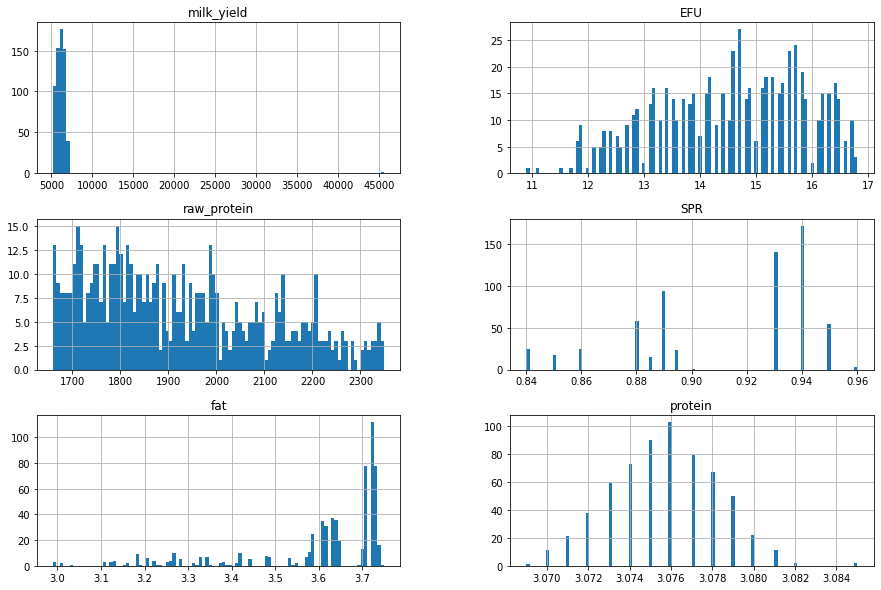

In [55]:
# Рассмотрим предварительно гистограммы распределений числовых признаков.

ferma_main[['milk_yield', 'EFU', 'raw_protein', 'SPR', 'fat', 'protein']].hist(bins=100, figsize=(15,10));

Нормальное распределение данных только в колонке белок (также есть аномалии).

Рассмотрим каждый показатель подробнее

Проверка визуальной нормальности

Возьмем признак белок в молоке, тк он визуально нормально распределен, можно будет сравнить параметры.

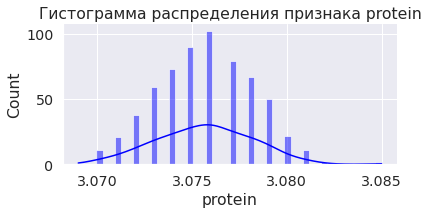

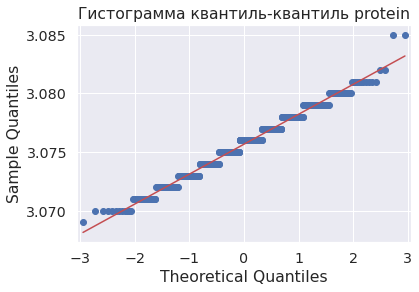

In [300]:
# Гистограмма распределения белка в молоке

sns.displot(ferma_main.protein,color='blue',label='protein', bins=50, kde=True, height=3, aspect=2)
plt.title(f'Гистограмма распределения признака protein')
plt.show();

# График квантиль-квантиль

qqplot(ferma_main.protein, line='s')
plt.title(f'Гистограмма квантиль-квантиль protein')
plt.show;

Визуально оба графика показывают нормальное разспределение с отклонениями в крайних частях графика (QQplot)

In [58]:
# Посчитаем коэффициент асиметрии

ferma_main.protein.skew()

0.06233462502310716

Значение незначительно больше нуля - график соотв. незначительно скошен влево относительно нормального распределения.

Используем критерии Шапиро-Уилка и Д’Агостино, чтобы окончательно принять или опровергнуть предположение о нормальном распределении. Примем уровень статистической значимости alpha=0.05

In [59]:
# Рассчитаем тест Шапиро-Уилка:

shapiro(ferma_main.protein)

ShapiroResult(statistic=0.9831634759902954, pvalue=1.2114685432607075e-06)

p-value значительно меньше заданного уровня статистической значимости. вот тут не понятно. предполагалось, что будет больше 0,05, а получилось сильно меньше.

In [60]:
# Рассчитаем тест Д'Агостино

normaltest(ferma_main.protein)

NormaltestResult(statistic=0.5179963570499226, pvalue=0.7718244289013547)

Тест Д'Агостино показывает, что распределение признака подчинено нормальному закону распределения, тк p-value > 0.05.

In [61]:
# Рассчитаем тест Андерсона

anderson(ferma_main.protein)

AndersonResult(statistic=4.0987891312141755, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Статистика теста составляет 4,09. При этом уровню статистической значимости = 0,01 (1%) соответстует критическое значение 1,085. Статистика превышает это критическое значение. Т.о. мы видим, что результаты являются значимыми уже при уровне 0,01 и далее. А это означает, что данные не распределены нормально.

Возможно, это связано с тем, что график не непрерывный, а ступенчатый.

(Это я смотрела, что получится с преобразованными данными. итоги теже )
#nums = ['EFU', 'SPR','fat','milk_yield','protein', 'raw_protein']
#ferma_main_transform = pd.DataFrame(PowerTransformer().fit_transform(ferma_main[nums]), columns=nums)

Проверим распределение для других числовых признаков

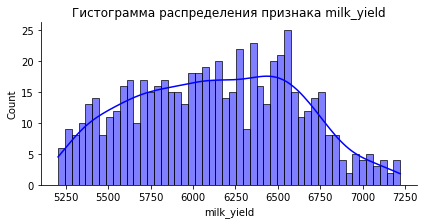

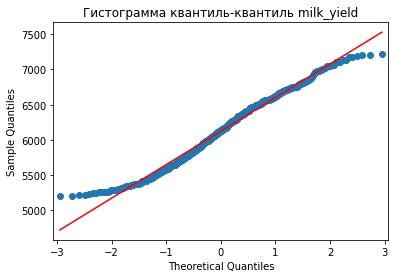

In [62]:
# Гистограмма распределения удоев

dp = ferma_main[ferma_main['milk_yield']<=10000]
sns.displot(dp.milk_yield,color='blue',label='milk_yield', bins=50, kde=True, height=3, aspect=2)
plt.title(f'Гистограмма распределения признака milk_yield')
plt.show();

# График квантиль-квантиль

qqplot(dp.milk_yield, line='s')
plt.title(f'Гистограмма квантиль-квантиль milk_yield')
plt.show;

In [63]:
# Посчитаем коэффициент асиметрии

dp.milk_yield.skew()

0.03223787829859327

График скошен влево. Но распределение, согласно этому коэффициенту близко к нормальному.

In [64]:
# Рассчитаем тест Шапиро-Уилка:

shapiro(dp.milk_yield)

ShapiroResult(statistic=0.981349527835846, pvalue=3.540204147611803e-07)

In [65]:
# Рассчитаем тест Д'Агостино

normaltest(dp.milk_yield)

NormaltestResult(statistic=59.99031532451491, pvalue=9.403045626891692e-14)

In [66]:
# Рассчитаем тест Андерсона

anderson(dp.milk_yield)

AndersonResult(statistic=2.711327926059994, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

А вот все тесты показывают, что распределение не является нормальным.

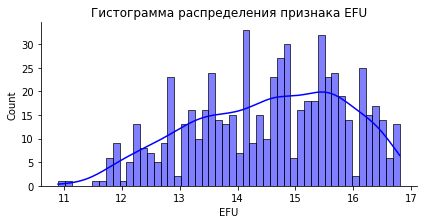

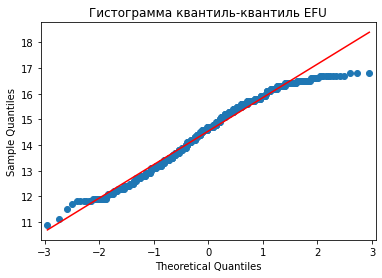

In [67]:
# Гистограмма распределения ЭКЕ

sns.displot(ferma_main.EFU,color='blue',label='EFU', bins=50, kde=True, height=3, aspect=2)
plt.title(f'Гистограмма распределения признака EFU')
plt.show();

# График квантиль-квантиль

qqplot(ferma_main.EFU, line='s')
plt.title(f'Гистограмма квантиль-квантиль EFU')
plt.show;

In [68]:
# Посчитаем коэффициент асиметрии

ferma_main.EFU.skew()

-0.3012187636452505

Значение меньше нуля, график скошен вправо.

In [69]:
# Рассчитаем тест Шапиро-Уилка:

shapiro(ferma_main.EFU)

ShapiroResult(statistic=0.971443772315979, pvalue=1.001851046567026e-09)

In [70]:
# Рассчитаем тест Д'Агостино

normaltest(ferma_main.EFU)

NormaltestResult(statistic=58.757162556035844, pvalue=1.7419844134800643e-13)

In [71]:
# Рассчитаем тест Андерсона

anderson(ferma_main.EFU)

AndersonResult(statistic=4.571100533956269, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Согласно всем признакам, распределение не является нормальным.

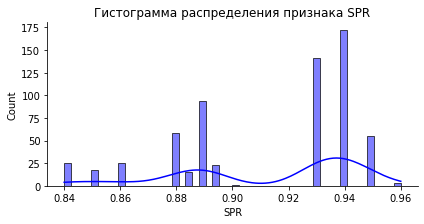

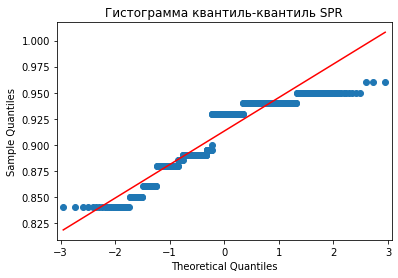

In [72]:
# Гистограмма распределения СПО

sns.displot(ferma_main.SPR,color='blue',label='SPR', bins=50, kde=True, height=3, aspect=2)
plt.title(f'Гистограмма распределения признака SPR')
plt.show();

# График квантиль-квантиль

qqplot(ferma_main.SPR, line='s')
plt.title(f'Гистограмма квантиль-квантиль SPR')
plt.show;

In [73]:
# Посчитаем коэффициент асиметрии

ferma_main.SPR.skew()

-0.6908837068953921

In [74]:
# Рассчитаем тест Шапиро-Уилка:

shapiro(ferma_main.SPR)

ShapiroResult(statistic=0.855368971824646, pvalue=1.4344963822622778e-23)

In [75]:
# Рассчитаем тест Д'Агостино

normaltest(ferma_main.SPR)

NormaltestResult(statistic=83.81457092710394, pvalue=6.308079697252198e-19)

In [76]:
# Рассчитаем тест Андерсона

anderson(ferma_main.SPR)

AndersonResult(statistic=39.57075828542315, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Этот параметр точно не относится к нормальному распределению. И да, выделяются 3 группы. Посмотрим, как лучше в модели их разделить.

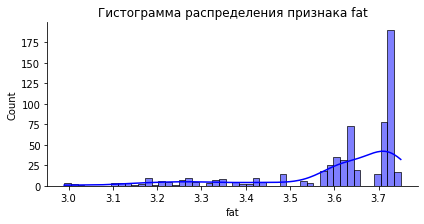

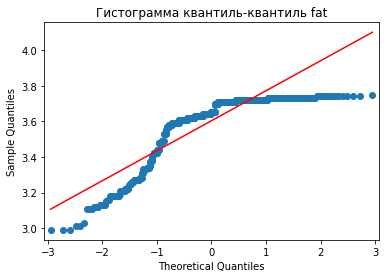

In [77]:
# Гистограмма распределения жирность молока

sns.displot(ferma_main.fat,color='blue',label='fat', bins=50, kde=True, height=3, aspect=2)
plt.title(f'Гистограмма распределения признака fat')
plt.show();

# График квантиль-квантиль

qqplot(ferma_main.fat, line='s')
plt.title(f'Гистограмма квантиль-квантиль fat')
plt.show;

In [78]:
# Посчитаем коэффициент асиметрии

ferma_main.fat.skew()

-1.6833325694855565

In [79]:
# Рассчитаем тест Шапиро-Уилка:

shapiro(ferma_main.fat)

ShapiroResult(statistic=0.742648720741272, pvalue=4.324465793850255e-30)

In [80]:
# Рассчитаем тест Д'Агостино

normaltest(ferma_main.fat)

NormaltestResult(statistic=187.97993724611766, pvalue=1.515916474455969e-41)

In [81]:
# Рассчитаем тест Андерсона

anderson(ferma_main.fat)

AndersonResult(statistic=60.91858801223748, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Здесь получаются 2 крупные группы признака и третья группа - прочее.

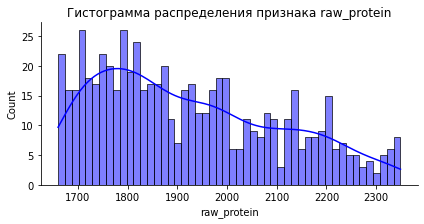

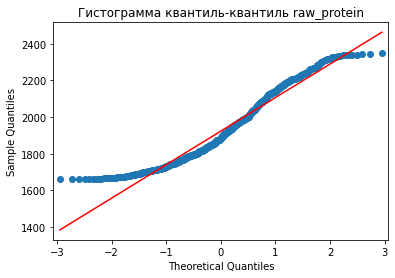

In [82]:
# Гистограмма распределения уровня сырого протеина в корме

sns.displot(ferma_main.raw_protein,color='blue',label='raw_protein', bins=50, kde=True, height=3, aspect=2)
plt.title(f'Гистограмма распределения признака raw_protein')
plt.show();

# График квантиль-квантиль

qqplot(ferma_main.raw_protein, line='s')
plt.title(f'Гистограмма квантиль-квантиль raw_protein')
plt.show;

In [83]:
# Посчитаем коэффициент асиметрии

ferma_main.raw_protein.skew()

0.5173061464973815

In [84]:
# Рассчитаем тест Шапиро-Уилка:

shapiro(ferma_main.raw_protein)

ShapiroResult(statistic=0.9435483813285828, pvalue=9.855809405905601e-15)

In [85]:
# Рассчитаем тест Д'Агостино

normaltest(ferma_main.raw_protein)

NormaltestResult(statistic=70.84910640297409, pvalue=4.1239369868459244e-16)

In [86]:
# Рассчитаем тест Андерсона

anderson(ferma_main.raw_protein)

AndersonResult(statistic=10.23817131546025, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Этот признак такж не распределен нормально

### Числовые данные: Диаграммы размаха, анализ выборосов и аномалий

Удой, кг

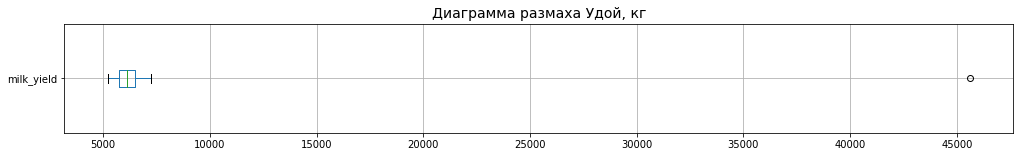

In [87]:
# Построим диаграмму размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = ferma_main[['milk_yield']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха Удой, кг', size = 14);

In [88]:
ferma_main[(ferma_main['milk_yield'] >= 10000)]

id  milk_yield   EFU  raw_protein   SPR   breed    pasture father_breed  \
16  17       45616  11.5         1675  0.93  Айдиал  холмистое       Айдиал   

     fat  protein   taste          age  
16  3.22    3.076  вкусно  более_2_лет

Единственное аномальное значение, которое намного превышает обычные данные. Стоит его удалить.

In [89]:
# Тут почему-то query перестал нормально работать, сделаю так:

ferma_main = ferma_main[ferma_main['milk_yield'] < 20000]

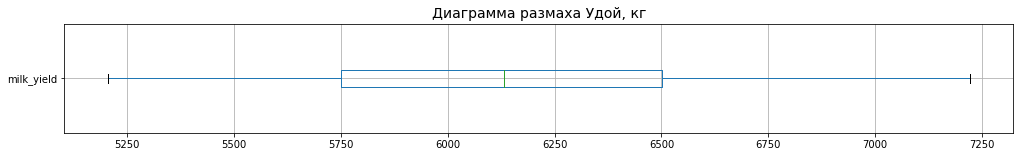

In [90]:
# Построим диаграмму размаха без аномалии

fig, ax = plt.subplots(figsize = (17,2))
ax = ferma_main[['milk_yield']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха Удой, кг', size = 14);

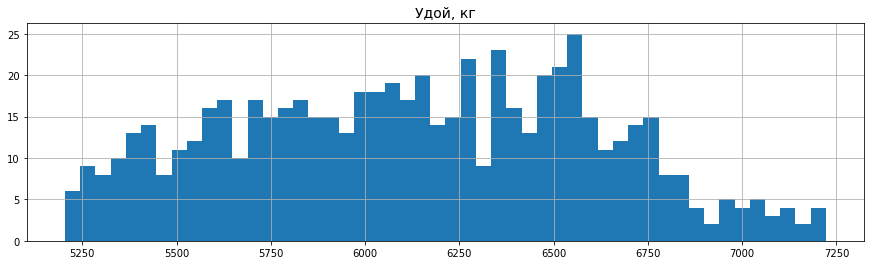

In [91]:
# Построим гистограмму

ferma_main['milk_yield'].hist(bins=50, figsize=(15,4)).set_title(label="Удой, кг", size=14);

Значимых выбросов не заметно. Коров с удоем свыше 6 800 кг меньше, чем остальных, но это не выбросы и не аномалии. 

Энергетическая кормовая единица (EFU - Energy feed unit)

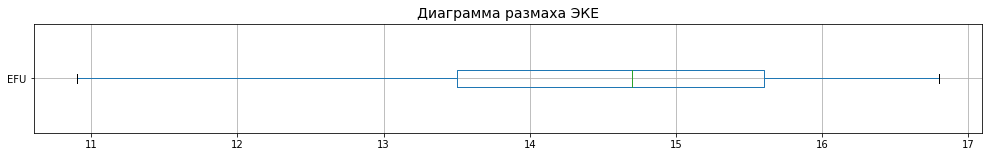

In [92]:
# Построим диаграмму размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = ferma_main[['EFU']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха ЭКЕ', size = 14);

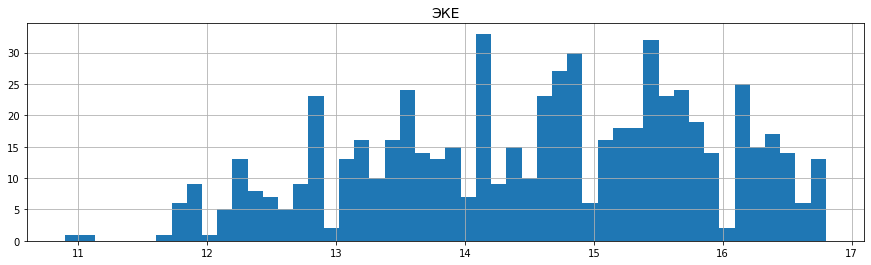

In [93]:
# Построим гистограмму

ferma_main['EFU'].hist(bins=50, figsize=(15,4)).set_title(label="ЭКЕ", size=14);

In [94]:
ferma_main.query('EFU<=11.5')

id  milk_yield   EFU  raw_protein   SPR     breed    pasture  \
456  457        5288  11.1         1925  0.88  Соверинг  равнинное   
581  582        5573  10.9         1955  0.84    Айдиал  холмистое   

    father_breed   fat  protein      taste          age  
456      Соверин  3.33    3.074  не вкусно  менее_2_лет  
581      Соверин  3.39    3.079     вкусно  менее_2_лет

2 значения сильно меньше остальных. Но, полагаю, удалять их не следует, тк на диаграмме размаха они отнесены к обычным значениям, не выбросам.

Сырой протеин, гр.

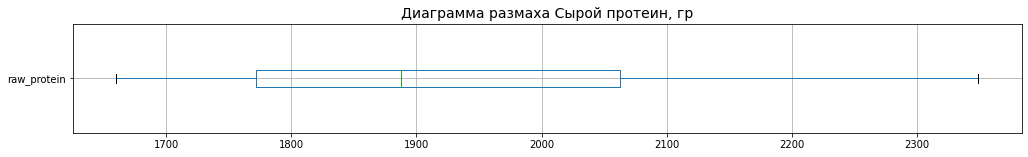

In [95]:
# Построим диаграмму размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = ferma_main[['raw_protein']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха Сырой протеин, гр', size = 14);

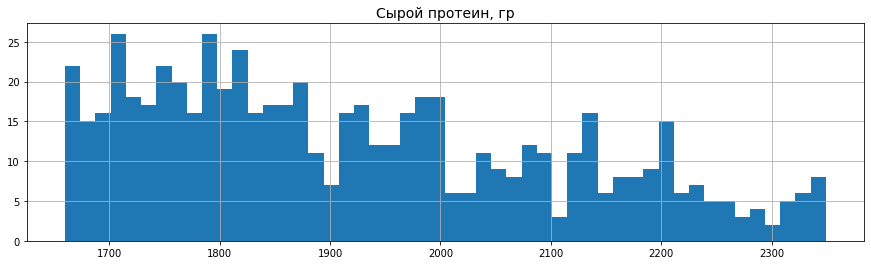

In [96]:
# Построим гистограмму

ferma_main['raw_protein'].hist(bins=50, figsize=(15,4)).set_title(label="Сырой протеин, гр", size=14);

Выбросов и явных аномалий не выявлено

Сахаро-протеиновое соотношение (SPR - Sugar-protein ratio)

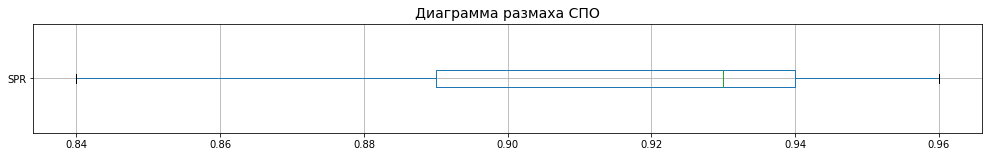

In [97]:
# Построим диаграмму размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = ferma_main[['SPR']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха СПО', size = 14);

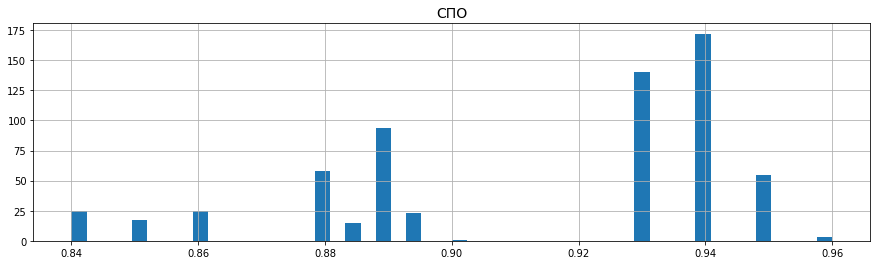

In [98]:
# Построим гистограмму

ferma_main['SPR'].hist(bins=50, figsize=(15,4)).set_title(label="СПО", size=14);

In [99]:
ferma_main.query('SPR >=0.96')

id  milk_yield   EFU  raw_protein   SPR     breed    pasture  \
44    45        7061  16.4         2041  0.96    Айдиал  холмистое   
190  191        6420  16.6         1966  0.96    Айдиал  равнинное   
620  621        6813  14.5         1712  0.96  Соверинг  равнинное   

    father_breed   fat  protein   taste          age  
44        Айдиал  3.72    3.079  вкусно  более_2_лет  
190      Соверин  3.73    3.077  вкусно  более_2_лет  
620       Айдиал  3.72    3.075  вкусно  более_2_лет

Выбросов и явных аномалий не выявлено

Жирность, %

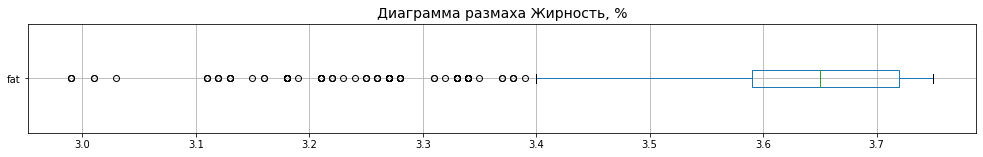

In [100]:
# Построим диаграмму размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = ferma_main[['fat']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха Жирность, %', size = 14);

In [101]:
# Выберем жирность < 3.1%

ferma_main.query('fat < 3.1')

id  milk_yield   EFU  raw_protein    SPR     breed    pasture  \
17    18        5777  12.4         1873  0.895    Айдиал  холмистое   
554  555        5686  14.7         1712  0.860  Соверинг  холмистое   
558  559        5346  12.4         1837  0.860  Соверинг  холмистое   
561  562        5300  13.0         1785  0.860    Айдиал  равнинное   
568  569        5989  13.2         1721  0.860    Айдиал  холмистое   
576  577        5376  11.7         1825  0.860  Соверинг  равнинное   

    father_breed   fat  protein      taste          age  
17        Айдиал  3.03    3.080     вкусно  более_2_лет  
554       Айдиал  3.01    3.074     вкусно  более_2_лет  
558      Соверин  3.01    3.078  не вкусно  менее_2_лет  
561      Соверин  2.99    3.077  не вкусно  менее_2_лет  
568      Соверин  2.99    3.076     вкусно  менее_2_лет  
576      Соверин  2.99    3.076  не вкусно  менее_2_лет

In [102]:
# Выберем жирность < 3.4%

ferma_main.query('fat < 3.4')['fat'].count()

86

Получается довольно много  - около 13%.

In [103]:
#ferma_main = ferma_main.query('fat >= 3.4') - если их удалить модель будет совсем плохенькая.

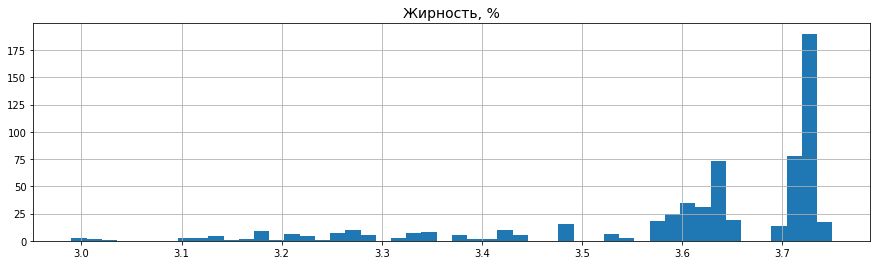

In [104]:
# Построим гистограмму

ferma_main['fat'].hist(bins=50, figsize=(15,4)).set_title(label="Жирность, %", size=14);

Ктипичным данным относится жирность от 3,4%. Однако число записей с жирностью меньше 3,4% довольно велико. Мы не можем их удалить без потери информации.

Белок, %

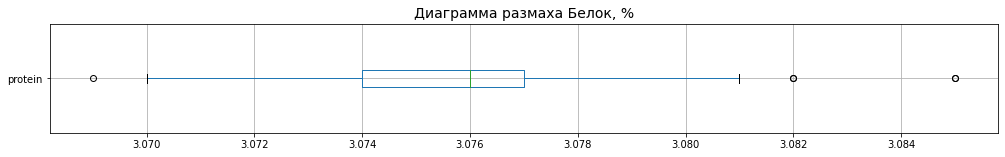

In [105]:
# Построим диаграмму размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = ferma_main[['protein']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха Белок, %', size = 14);

In [106]:
ferma_main.query('protein < 3.070 or protein > 3.081').sort_values(by='protein')
#['protein'].count()

id  milk_yield   EFU  raw_protein    SPR     breed    pasture  \
240  241        5568  13.4         1733  0.880    Айдиал  равнинное   
77    78        5871  14.7         1795  0.895    Айдиал  равнинное   
426  427        6701  15.7         2068  0.940  Соверинг  холмистое   
471  472        5883  14.9         2159  0.890    Айдиал  равнинное   
517  518        5819  13.7         1968  0.840    Айдиал  холмистое   

    father_breed   fat  protein      taste          age  
240      Соверин  3.63    3.069  не вкусно  менее_2_лет  
77        Айдиал  3.61    3.082     вкусно  более_2_лет  
426       Айдиал  3.72    3.082     вкусно  более_2_лет  
471      Соверин  3.62    3.085     вкусно  более_2_лет  
517       Айдиал  3.15    3.085     вкусно  более_2_лет

In [107]:
ferma_main = ferma_main.query('protein >= 3.070 or protein <= 3.081')

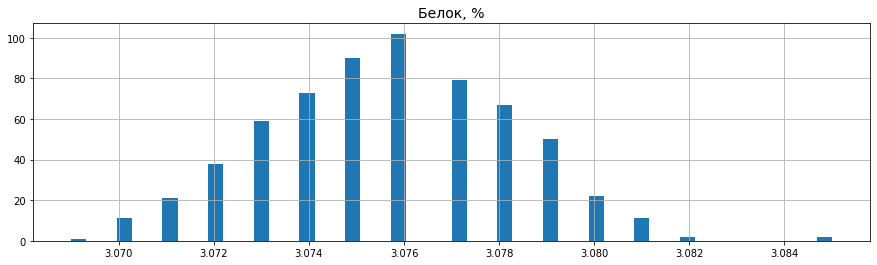

In [108]:
# Построим гистограмму

ferma_main['protein'].hist(bins=50, figsize=(15,4)).set_title(label="Белок, %", size=14);

Диаграмма размаха показывает 5 значений, как выбросы, но удалять их я бы не стала, тк значения не аномальные. А для оценки вкуса, например, могут быть важными низкие и высокие показатели белка в молоке.

Гистограмма показывает нормальное распределение признака. Наибольшее число значений составляет 3,076% белка.

### Категориальные данные: Общий анализ и круговые диаграммы, взаимосвязи признаков

Перейдем к категориальным признакам

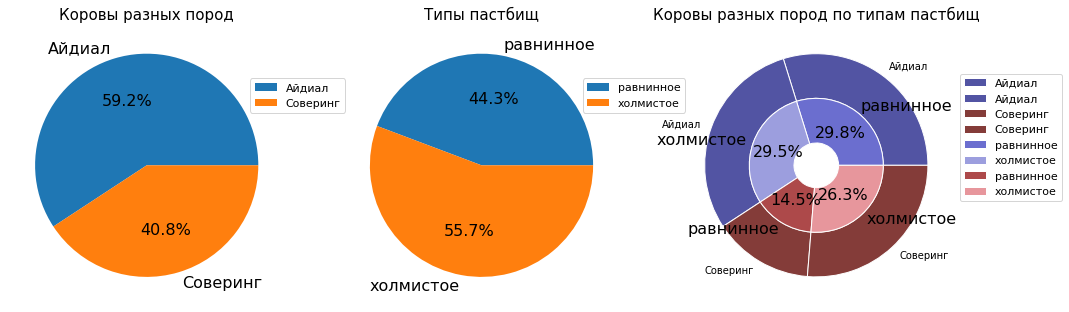

In [111]:
fig, axs = plt.subplots(1, 3, figsize=(17, 7))

breeds = ferma_main.groupby('breed')['breed'].agg('count').to_frame().rename(columns = {'breed':'count'})
pasture = ferma_main.groupby('pasture')['pasture'].agg('count').to_frame().rename(columns = {'pasture':'count'})
b_p = ferma_main.groupby(['breed', 'pasture'])['id'].agg('count').to_frame().rename(columns = {'id':'count'}).reset_index()

font_size = 16

axs[0].pie(breeds['count'], labels=breeds.index, autopct='%1.1f%%', textprops={'fontsize': font_size});
axs[0].set_title('Коровы разных пород', fontsize=15)
axs[0].legend(bbox_to_anchor=[1.23, 0.75], loc='center right', fontsize=11);

axs[1].pie(pasture['count'], labels=pasture.index, autopct='%1.1f%%', textprops={'fontsize': font_size});
axs[1].set_title('Типы пастбищ', fontsize=15)
axs[1].legend(bbox_to_anchor=[1.25, 0.75], loc='center right', fontsize=11);

cmap = plt.get_cmap('tab20b')
b_colors = cmap(np.array([1, 1, 12, 12]))
sm_colors = cmap(np.array([2, 3, 13, 15]))
axs[2].pie(b_p.sum(axis=1), radius=1, labels = b_p.breed, colors = b_colors, wedgeprops=dict(width=0.4, edgecolor='w'))
axs[2].pie(b_p['count'], radius=1-0.4,  labels = b_p.pasture, colors = sm_colors, wedgeprops=dict(width=0.4, edgecolor='w'),\
           autopct='%1.1f%%', textprops={'fontsize': font_size})
axs[2].set_title('Коровы разных пород по типам пастбищ', fontsize=15)
axs[2].legend(bbox_to_anchor=[1.40, 0.60], loc='center right', fontsize=11);

Коров породы "Айдиал" на 19% больше, чем "Соверинг"

Пастбищ холмистого типа на 11% больше, чем равнинных

Коровы породы "Айдиал" выпасаются примерно по ровну на холмистых и равнинных пастбищах, а коровы породы "Соверинг" почти в 2 раза больше выпасаются на холмистых и только ~ 1/3 на равнинных.

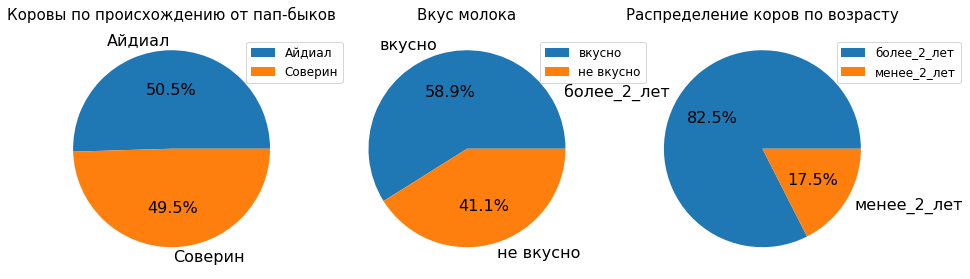

In [112]:
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

f_breeds = ferma_main.groupby('father_breed')['father_breed'].agg('count').to_frame().rename(columns = {'father_breed':'count'})
taste = ferma_main.groupby('taste')['taste'].agg('count').to_frame().rename(columns = {'taste':'count'})
age = ferma_main.groupby('age')['age'].agg('count').to_frame().rename(columns = {'age':'count'})

font_size = 16

axs[0].pie(f_breeds['count'], labels=f_breeds.index, autopct='%1.1f%%', textprops={'fontsize': font_size});
axs[0].set_title('Коровы по происхождению от пап-быков', fontsize=15)
axs[0].legend(bbox_to_anchor=[1.22, 0.85], loc='center right', fontsize=12);

axs[1].pie(taste['count'], labels=taste.index, autopct='%1.1f%%', textprops={'fontsize': font_size});
axs[1].set_title('Вкус молока', fontsize=15)
axs[1].legend(bbox_to_anchor=[1.25, 0.85], loc='center right', fontsize=12);

axs[2].pie(age['count'], labels=age.index, autopct='%1.1f%%', textprops={'fontsize': font_size});
axs[2].set_title('Распределение коров по возрасту', fontsize=15)
axs[2].legend(bbox_to_anchor=[1.33, 0.85], loc='center right', fontsize=12);

Практически поровну коров происходит от пород "Айдиал" и "Соверин".

~ 60% коров дают вкусное молоко, ~ 40% - не вкусное.

Основная часть поголовья (82,5%) - старше 2-х лет, 17,5% - моложе 2-х лет.

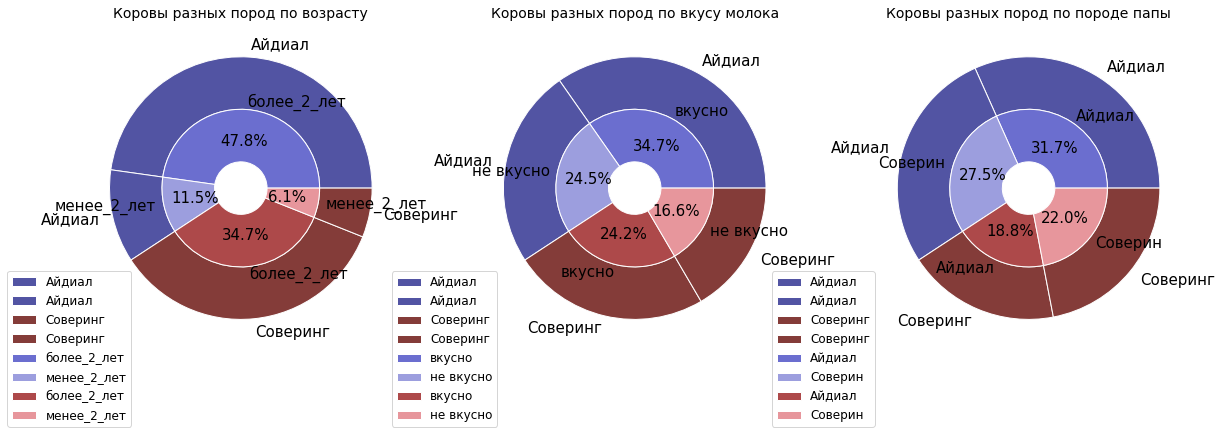

In [113]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

b_fb = ferma_main.groupby(['breed', 'father_breed'])['father_breed'].agg(
    'count'
).to_frame(
).rename(
    columns = {'father_breed':'count'}).reset_index(
)

b_t = ferma_main.groupby(['breed', 'taste'])['taste'].agg(
    'count'
).to_frame(
).rename(
    columns = {'taste':'count'}).reset_index(
)

b_a = ferma_main.groupby(['breed', 'age'])['age'].agg(
    'count'
).to_frame(
).rename(
    columns = {'age':'count'}).reset_index(
)

cmap = plt.get_cmap('tab20b')
b_colors = cmap(np.array([1, 1, 12, 12]))
sm_colors = cmap(np.array([2, 3, 13, 15]))

font_size = 15

axs[0].pie(b_a.sum(axis=1), radius=1, labels = b_a.breed, colors = b_colors, wedgeprops=dict(width=0.4, edgecolor='w'),\
           textprops={'fontsize': font_size})
axs[0].pie(b_a['count'], radius=1-0.4,  labels = b_a.age, colors = sm_colors, wedgeprops=dict(width=0.4, edgecolor='w'),\
           autopct='%1.1f%%', textprops={'fontsize': font_size})
axs[0].set_title('Коровы разных пород по возрасту', fontsize=14)
axs[0].legend(bbox_to_anchor=[-0.23, 0.01], loc='center left', fontsize=12);

axs[1].pie(b_t.sum(axis=1), radius=1, labels = b_t.breed, colors = b_colors, wedgeprops=dict(width=0.4, edgecolor='w'),\
           textprops={'fontsize': font_size})
axs[1].pie(b_t['count'], radius=1-0.4, labels = b_t.taste, colors = sm_colors, wedgeprops=dict(width=0.4, edgecolor='w'),\
           autopct='%1.1f%%', textprops={'fontsize': font_size})
axs[1].set_title('Коровы разных пород по вкусу молока', fontsize=14)
axs[1].legend(bbox_to_anchor=[0.1, 0.01], loc='right', fontsize=12);

axs[2].pie(b_fb.sum(axis=1), radius=1, labels = b_fb.breed, colors = b_colors, wedgeprops=dict(width=0.4, edgecolor='w'),\
           textprops={'fontsize': font_size})
axs[2].pie(b_fb['count'], radius=1-0.4, labels = b_fb.father_breed, colors = sm_colors,\
           wedgeprops=dict(width=0.4, edgecolor='w'), autopct='%1.1f%%', textprops={'fontsize': font_size})
axs[2].set_title('Коровы разных пород по породе папы', fontsize=14)
axs[2].legend(bbox_to_anchor=[0.05, 0.01], loc='center right', fontsize=12);

In [114]:
#ferma_main.pivot_table(index=['breed', 'pasture'], values=['yield'], aggfunc=('mean'))

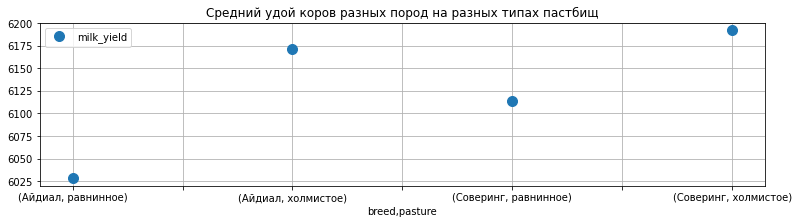

In [115]:
# Рассмотрим средний удой по породам коров и типу пастбищ

ferma_main.pivot_table(
    index=['breed', 'pasture'], values=['milk_yield'], aggfunc=('mean')
).plot(
    title=("Средний удой коров разных пород на разных типах пастбищ"),
    style="o",
    grid=True,
    figsize=(13,3),
    ms = 10,
); 

Средний удой выше у коров породы "Северинг", нежели "Айдиал".
Коровы, выпасающиеся на холмистых пастбищах имеют более высокий средний удой, чем на равнинных пастбищах.
Минимальный срдений удой у коров породы "Айдиал" с равнинных пастбищ.

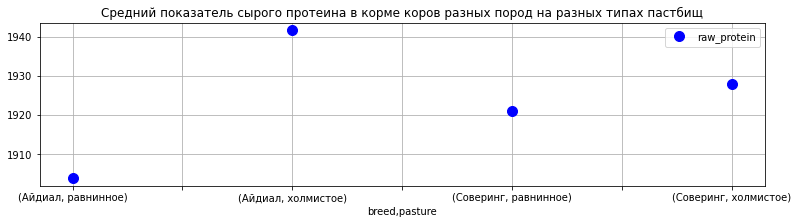

In [116]:
# Рассмотрим средний показатель сырого протеина в корме по породам коров и типу пастбищ

ferma_main.pivot_table(
    index=['breed', 'pasture'], values=['raw_protein'], aggfunc=('mean')
).plot(
    title=("Средний показатель сырого протеина в корме коров разных пород на разных типах пастбищ"),
    style="o",
    c='b',
    grid=True,
    figsize=(13,3),
    ms = 10
); 

Средний показатель сырого протеина в корме выше у коров, выпасающихся на холмистых пастбищах, нежели на равнинных. 
Здесь на первом месте коровы породы "Айдиал" с холмистых пастбищ, затем идут коровы породы "Северинг" с холмистых и равнинных пастбищ. Минимальный средний показатель сырого протеина в корме коров породы "Айдиал" с равнинных пастбищ.

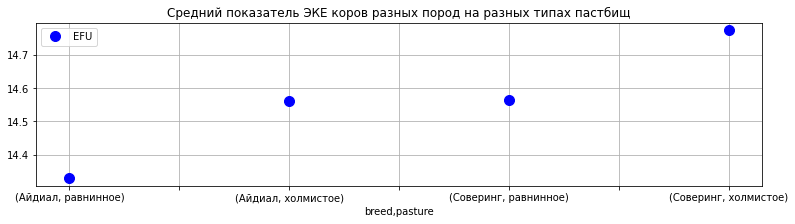

In [117]:
# Рассмотрим средний показатель ЭКЕ по породам коров и типу пастбищ

ferma_main.pivot_table(
    index=['breed', 'pasture'], values=['EFU'], aggfunc=('mean')
).plot(
    title=("Средний показатель ЭКЕ коров разных пород на разных типах пастбищ"),
    style="o",
    c='b',
    grid=True,
    figsize=(13,3),
    ms = 10
); 

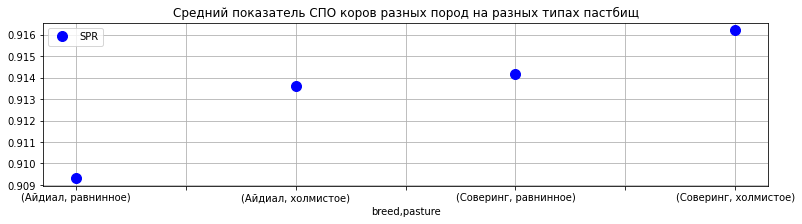

In [118]:
# Рассмотрим средний показатель ЭКЕ по породам коров и типу пастбищ

ferma_main.pivot_table(
    index=['breed', 'pasture'], values=['SPR'], aggfunc=('mean')
).plot(
    title=("Средний показатель СПО коров разных пород на разных типах пастбищ"),
    style="o",
    c='b',
    grid=True,
    figsize=(13,3),
    ms = 10
); 

По показателям ЭКЕ и СПО коровы породы "Северинг" опережают коров породы "Айдиал". Коровы обеих пород, выпасающиеся на холмистых пастбиах показывают более высокий средний показатель ЭКЕ, по сравнению с равнинными пастбищами.

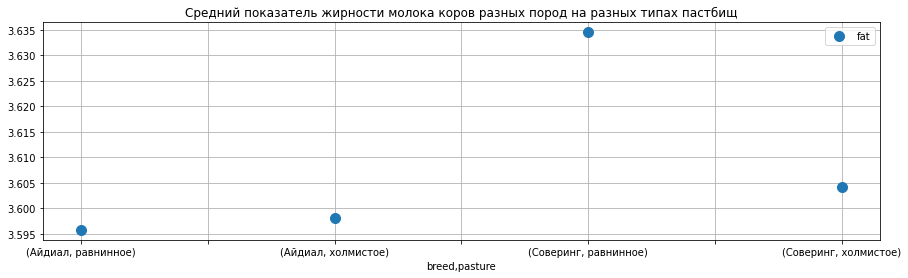

In [119]:
# Рассмотрим средний показатель жирности молока по породам коров и типу пастбищ

ferma_main.pivot_table(
    index=['breed', 'pasture'], values=['fat'], aggfunc=('mean')
).plot(
    title=("Средний показатель жирности молока коров разных пород на разных типах пастбищ"),
    style="o",
    grid=True,
    figsize=(15,4),
    ms = 10
); 

Интересно, по показателю средней жирности молока на первом месте коровы породы "Северинг" с равнинных пастбищ. Это значение намного превышает остальные. 
На втором месте также коровы породы "Северинг", но уже с холмистых пастбищ.

Молоко коров породы "Айдиал" гораздо менее жирное, чем у породы "Северинг". И сохраняется общая тенденция: на холмистых пастбищах показатели выше, нежели на равнинных.

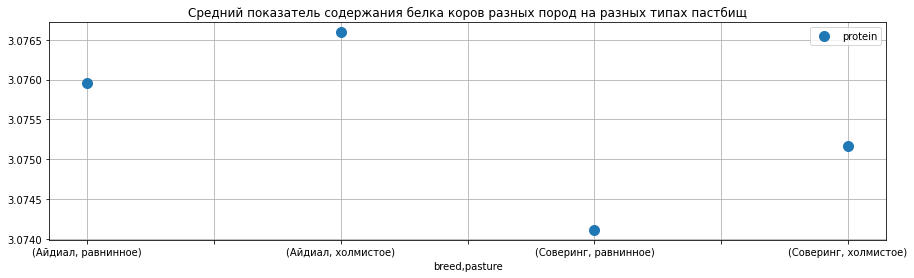

In [120]:
# Рассмотрим средний показатель содержания белка по породам коров и типу пастбищ

ferma_main.pivot_table(
    index=['breed', 'pasture'], values=['protein'], aggfunc=('mean')
).plot(
    title=("Средний показатель содержания белка коров разных пород на разных типах пастбищ"),
    style="o",
    grid=True,
    figsize=(15,4),
    ms = 10
); 

По среднему уровню белка в молоке можно отметить выявленную ранее особенность: на холмистых пастбищах показатель выше, чем на равнинных. 
Однако в данном случае, коровы породы "Айдиал" намного опережают коров породы "Северинг".

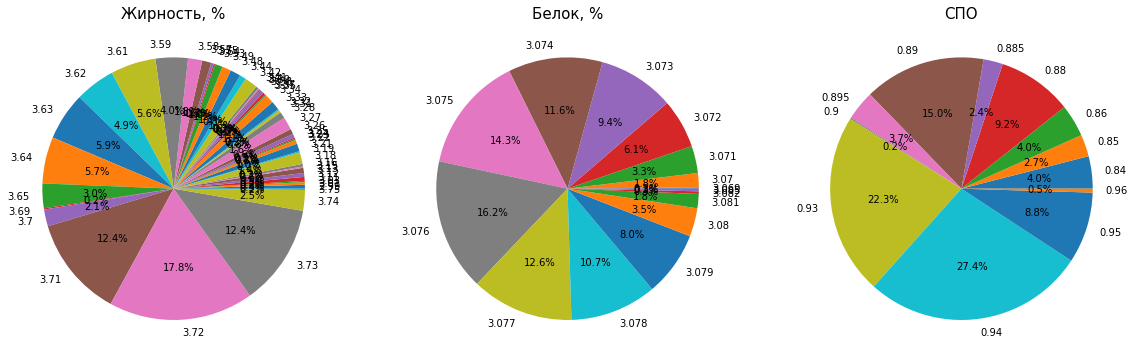

In [121]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

f_f = ferma_main.groupby('fat')['fat'].agg('count').to_frame().rename(columns = {'fat':'count'})
f_p = ferma_main.groupby('protein')['protein'].agg('count').to_frame().rename(columns = {'protein':'count'})
f_spr = ferma_main.groupby('SPR')['SPR'].agg('count').to_frame().rename(columns = {'SPR':'count'})
f_efu = ferma_main.groupby('EFU')['EFU'].agg('count').to_frame().rename(columns = {'EFU':'count'})

cmap = plt.get_cmap('tab20b')
b_colors = cmap(np.array([0, 1, 18, 13]))
sm_colors = cmap(np.array([2, 3, 19, 15]))

axs[0].pie(f_f['count'], labels=f_f.index, autopct='%1.1f%%');
axs[0].set_title('Жирность, %', fontsize=15)

axs[1].pie(f_p['count'], labels=f_p.index, autopct='%1.1f%%');
axs[1].set_title('Белок, %', fontsize=15)

axs[2].pie(f_spr['count'], labels=f_spr.index, autopct='%1.1f%%')
axs[2].set_title('СПО', fontsize=15);

По жирности можно выделить 3 ключевые группы (42% всех данных): 3,72 - составляет 17,8% всех данных, 3,71 и 3,73 - по 12,4%.
По содержанию белка: 3,076 составляет 16,2% всех данных, 3,075 - 14,3% 3,077 - 12,6%. 74,8% всех данных составля.т показатели белка от 3,073 до 3,078.
По СПО - основную долю (27,4%) занимает покзатель 0,94. Показатели 0,93-0,95 составляю.т 58,5% данных.

### Исследовательский анализ данных 2 и 3 файлов

Рассмотрим данные 2го файла

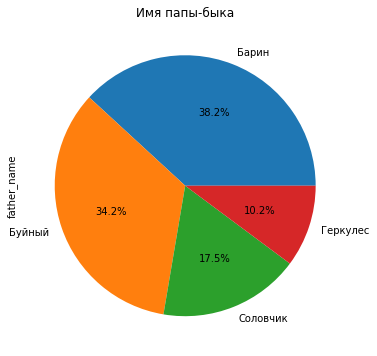

In [122]:
ferma_dad['father_name'].value_counts().plot(kind='pie', figsize=(10,6), title=("Имя папы-быка"), autopct='%1.1f%%');

Основная часть коров происходит от быка "Барин" - 38,2% и "Буйный" - 34,2%.

Перейдем к 3му файлу.

In [123]:
cow.describe()

fat    protein
count  20.000000  20.000000
mean    3.577500   3.069500
std     0.126818   0.010339
min     3.340000   3.046000
25%     3.510000   3.064000
50%     3.590000   3.074000
75%     3.650000   3.076000
max     3.770000   3.081000

Судя по квартилям, данные довольно равномерны и однородны, без аномальных значений.

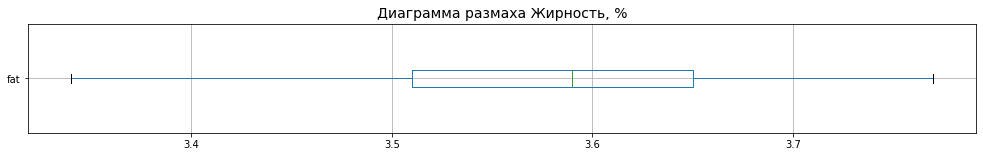

In [124]:
# Построим диаграмму размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = cow[['fat']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха Жирность, %', size = 14);

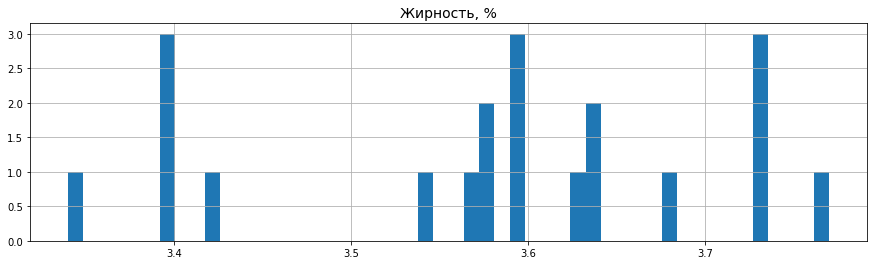

In [125]:
# Построим гистограмму

cow['fat'].hist(bins=50, figsize=(15,4)).set_title(label="Жирность, %", size=14);

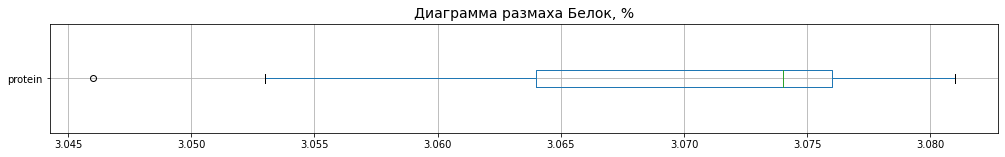

In [126]:
# Построим диаграмму размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = cow[['protein']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха Белок, %', size = 14);

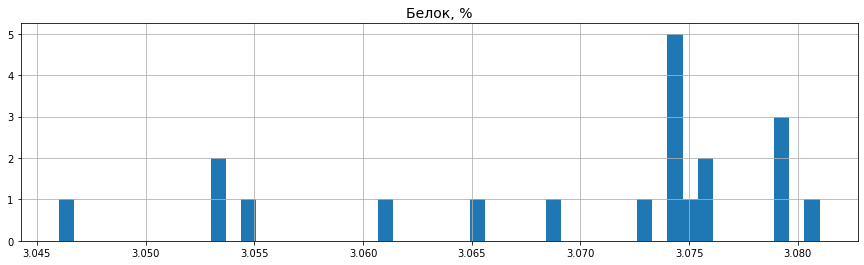

In [127]:
# Построим гистограмму

cow['protein'].hist(bins=50, figsize=(15,4)).set_title(label="Белок, %", size=14);

Выбросов и аномалий нет.

Категориальные данные

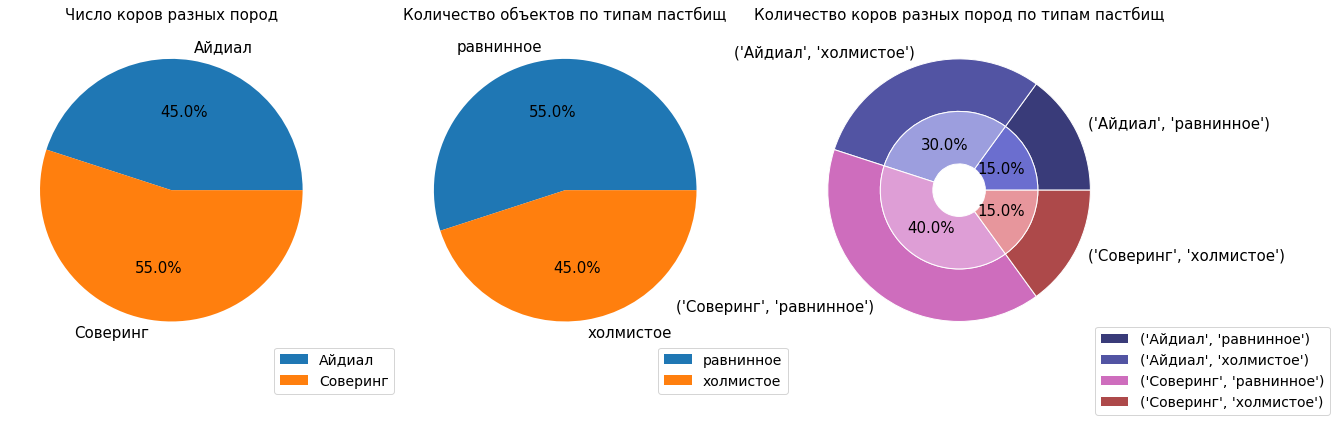

In [128]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))

с_breeds = cow.groupby('breed')['breed'].agg('count').to_frame().rename(columns = {'breed':'count'})
с_pasture = cow.groupby('pasture')['pasture'].agg('count').to_frame().rename(columns = {'pasture':'count'})
с_p = cow.groupby(['breed', 'pasture'])['breed'].agg('count').to_frame().rename(columns = {'breed':'count'})

font_size = 15

axs[0].pie(с_breeds['count'], labels=с_breeds.index, autopct='%1.1f%%', textprops={'fontsize': font_size});
axs[0].set_title('Число коров разных пород', fontsize=15)
axs[0].legend(bbox_to_anchor=[1.2, -0.05], loc='center right', fontsize=14);

axs[1].pie(с_pasture['count'], labels=с_pasture.index, autopct='%1.1f%%', textprops={'fontsize': font_size});
axs[1].set_title('Количество объектов по типам пастбищ', fontsize=15)
axs[1].legend(bbox_to_anchor=[1.2, -0.05], loc='center right', fontsize=14);

cmap = plt.get_cmap('tab20b')
b_colors = cmap(np.array([0, 1, 18, 13]))
sm_colors = cmap(np.array([2, 3, 19, 15]))

axs[2].pie(с_p.sum(axis=1), radius=1, labels = с_p.index, colors = b_colors, wedgeprops=dict(width=0.4, edgecolor='w'),\
           textprops={'fontsize': font_size})
axs[2].pie(с_p['count'], radius=1-0.4,  colors = sm_colors, wedgeprops=dict(width=0.4, edgecolor='w'), autopct='%1.1f%%',\
           textprops={'fontsize': font_size})
axs[2].set_title('Количество коров разных пород по типам пастбищ', fontsize=15)
axs[2].legend(bbox_to_anchor=[1.65, -0.05], loc='center right', fontsize=14);

В данном файле коровы и пастбища распределены поровну  

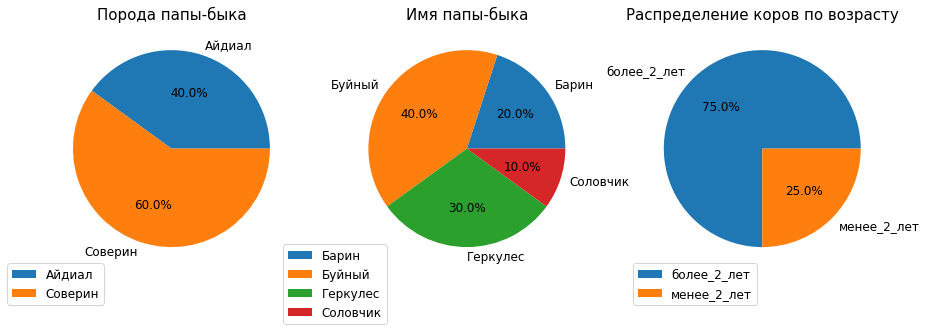

In [129]:
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

c_f_breeds = cow.groupby('father_breed')['father_breed'].agg('count').to_frame().rename(columns = {'father_breed':'count'})
c_f_name = cow.groupby('father_name')['father_name'].agg('count').to_frame().rename(columns = {'father_name':'count'})
c_age = cow.groupby('age')['age'].agg('count').to_frame().rename(columns = {'age':'count'})

font_size = 12

axs[0].pie(c_f_breeds['count'], labels=c_f_breeds.index, autopct='%1.1f%%', textprops={'fontsize': font_size});
axs[0].set_title('Порода папы-быка', fontsize=15)
axs[0].legend(bbox_to_anchor=[0.25, -0.05], loc='center right', fontsize=12);

axs[1].pie(c_f_name['count'], labels=c_f_name.index, autopct='%1.1f%%', textprops={'fontsize': font_size});
axs[1].set_title('Имя папы-быка', fontsize=15)
axs[1].legend(bbox_to_anchor=[-0.27, -0.05], loc='center left', fontsize=12);

axs[2].pie(c_age['count'], labels=c_age.index, autopct='%1.1f%%', textprops={'fontsize': font_size});
axs[2].set_title('Распределение коров по возрасту', fontsize=15)
axs[2].legend(bbox_to_anchor=[-0.05, -0.05], loc='center left', fontsize=12);

В данной выборке большую часть коров составляет порода "Соверин" - 62,5%, "Айдиал", соотв. - 37,5%.

Основная часть коров происходит от быков "Буйный" - 43,8% и "Геркулес"- 31,2%.

Поголовье более молодое: коров старше 2-х лет 68,8%, младше 2-х лет - 31,2%.

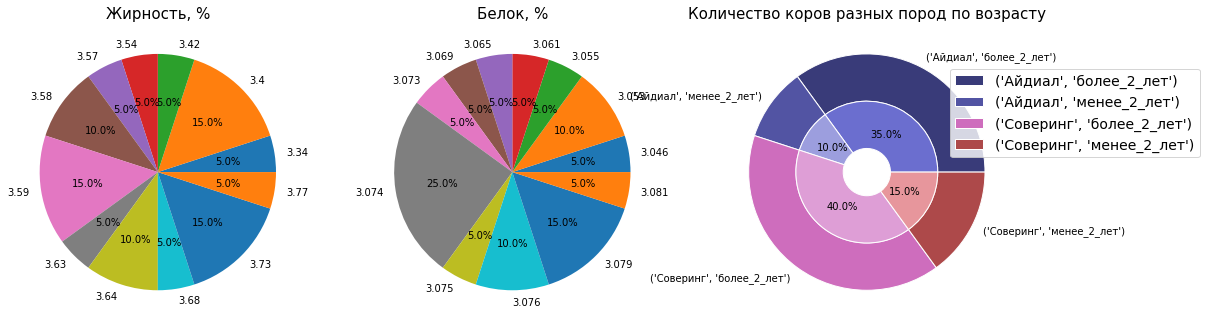

In [130]:
fig, axs = plt.subplots(1, 3, figsize=(18, 7))

c_f = cow.groupby('fat')['fat'].agg('count').to_frame().rename(columns = {'fat':'count'})
c_p = cow.groupby('protein')['protein'].agg('count').to_frame().rename(columns = {'protein':'count'})
c_b_a = cow.groupby(['breed', 'age'])['age'].agg('count').to_frame().rename(columns = {'age':'count'})

cmap = plt.get_cmap('tab20b')
b_colors = cmap(np.array([0, 1, 18, 13]))
sm_colors = cmap(np.array([2, 3, 19, 15]))

axs[0].pie(c_f['count'], labels=c_f.index, autopct='%1.1f%%');
axs[0].set_title('Жирность, %', fontsize=15)
#axs[0].legend(bbox_to_anchor=[0.25, 0.75], loc='center right', fontsize=12);

axs[1].pie(c_p['count'], labels=c_p.index, autopct='%1.1f%%');
axs[1].set_title('Белок, %', fontsize=15)
#axs[1].legend(bbox_to_anchor=[-0.27, 0.55], loc='center left', fontsize=12);

axs[2].pie(c_b_a.sum(axis=1), radius=1, labels = c_b_a.index, colors = b_colors, wedgeprops=dict(width=0.4, edgecolor='w'))
axs[2].pie(c_b_a['count'], radius=1-0.4,  colors = sm_colors, wedgeprops=dict(width=0.4, edgecolor='w'), autopct='%1.1f%%')
axs[2].set_title('Количество коров разных пород по возрасту', fontsize=15)
axs[2].legend(bbox_to_anchor=[1.65, 0.7], loc='center right', fontsize=14);

Интересное распределение жирности: 2 группы по 18,8% общего объема с жирностью 3,4 и 3,73, а остальные жирности составляют по 6,2%.

Наиболее частые показатели белка = 3,079 составляют 18,8% общего объема данных. 2 группы с показателями белка = 3,053 и 3,074 составляют по 12,5%. Остальные группы занимают также по 6,2%.

Коров породы "Айдиал" возрастом более 2х лет чуть больше (37,5%) , чем коров породы "Соверинг" тогоже возраста (31,2%).
Коров возрастом до 2-х лет соотв. - 12,5% "Айдиал" и 18,8% "Соверинг". 

**Вывод:**

Проведен исследовательский анализ данных. 
Удалено аномально высокое значение показателя удой. Выбросы в показателях жирность молока и содержание белка в молоке сохранены, чтобы избежать потери данных. 
Наиболее равномерно распределен показатель белок в молоке.

Отметим выявленные особенности и взаимосвязи данных.

Средний удой составляет 6 188 кг. от 25 до 75% покзателей в диапазоне 5 751 - 6 501 кг. 
Срдение показатели жиности молока - 3,6%, белка в молоке - 3,076%.

Средний уровень протеина в корме коров = 1 923г, при разбросе 25 - 75% = 1 771 - 2 062г. 
Средний показатель ЭКЕ = 14,54, СПО = 0,91.

Большую часть в данных составляют коровы породы Айдиал - 59,2%, выпасаются большая часть животных на холмистых пастбищах - 55,7%, вкусное молоко у 58,9% особей, 82,5% составляют животные возраста больше 2-х лет. По происхождению от быков 2-х пород коровы распределены практически равномерно (50,5% - от быков породы Айдиал, 49,5% от быков породы Соверинг).

Тип пастбища играет довольно большое влияние на показатели молока. Внутри пород на холмистых пастбищах отмечены лучшие показатели удоя молока, протеина в корме, ЭКЕ, СПО и белка в молоке.
Из общих данных выделяется показатель жирности молока - он выше у коров породы Соверинг, выпасающихся на равнинных пастбищах.

Средний удой и жирности молока выше у коров породы Соверинг.
Содержание белка в молоке выыше у коров породы Айдиал, также как и протеина в корме.

Примерно равные группы коров происходят от быков Барин - 38,2% и Буйный - 34,2%, в 2 раза меньше - от быка Соловкчик - 17,5%, и минимальное число от быка Геркулес - 10,2%.

В датафрейме с отобранными для рассмотрения коровами покзатели жиности молока и белка в молоке несколько ниже - 3,578% и 3,07% соответсвенно.
Большую часть составляют коровы породы Соверинг - 55%, выпасаются в основном на равнинных пастбищах - 55%, 60% коров происходят от быка породы Соверинг. 40% коров от быка Буйный, 30% от быка Геркулес. По возрасту 75% коров старше 2х лет.

### Анализ данных по подгруппам

In [131]:
# Сделаем для исследования две выборки с породами коров

df_ideal = ferma_main[(ferma_main['breed'] == "Айдиал")&(ferma_main['milk_yield'] <= 10000)].drop(['id'], axis=1)
df_sovering = ferma_main[ferma_main['breed'] == "Соверинг"].drop(['id'], axis=1)

In [132]:
# Выведем описание числовых данных породы Айдиал

df_ideal.describe()

milk_yield         EFU  raw_protein         SPR         fat  \
count   372.000000  372.000000   372.000000  372.000000  372.000000   
mean   6099.405914   14.444624  1922.620968    0.911438    3.596935   
std     462.472692    1.320315   181.904551    0.032856    0.167189   
min    5242.000000   10.900000  1661.000000    0.840000    2.990000   
25%    5715.500000   13.400000  1777.500000    0.890000    3.580000   
50%    6112.000000   14.600000  1885.500000    0.930000    3.640000   
75%    6468.250000   15.600000  2064.000000    0.940000    3.720000   
max    7222.000000   16.800000  2349.000000    0.960000    3.750000   

          protein  
count  372.000000  
mean     3.076274  
std      0.002477  
min      3.069000  
25%      3.074000  
50%      3.076000  
75%      3.078000  
max      3.085000

In [133]:
# Выведем описание числовых данных породы Соверинг

df_sovering.describe()

milk_yield         EFU  raw_protein         SPR         fat  \
count   256.000000  256.000000   256.000000  256.000000  256.000000   
mean   6164.566406   14.700000  1925.414062    0.915488    3.614922   
std     493.026392    1.261652   184.517964    0.031183    0.169157   
min    5204.000000   11.100000  1660.000000    0.840000    2.990000   
25%    5771.000000   13.800000  1769.000000    0.890000    3.620000   
50%    6178.500000   14.900000  1889.500000    0.930000    3.700000   
75%    6559.250000   15.700000  2056.500000    0.940000    3.720000   
max    7201.000000   16.800000  2346.000000    0.960000    3.740000   

          protein  
count  256.000000  
mean     3.074793  
std      0.002403  
min      3.070000  
25%      3.073000  
50%      3.075000  
75%      3.076000  
max      3.082000

По удоям коровы породы Соверинг показывают чуть лучшие данные. Также у них чуть лучше показатель ЭКЕ.

In [134]:
# Посмотрим средние значения в разбивке по типам пастбищ породы Айдиал

df_ideal.pivot_table(index=['pasture', 'father_breed'], aggfunc=('mean'))

EFU       SPR       fat   milk_yield   protein  \
pasture   father_breed                                                         
равнинное Айдиал        14.508911  0.916386  3.603267  6154.811881  3.076158   
          Соверин       14.116279  0.900988  3.586977  5879.302326  3.075721   
холмистое Айдиал        14.677551  0.919592  3.596531  6376.755102  3.076786   
          Соверин       14.432184  0.906839  3.599885  5940.241379  3.076379   

                        raw_protein  
pasture   father_breed               
равнинное Айдиал        1886.227723  
          Соверин       1924.313953  
холмистое Айдиал        1959.724490  
          Соверин       1921.402299

In [135]:
# Посмотрим средние значения в разбивке по типам пастбищ породы Соверинг

df_sovering.pivot_table(index=['pasture', 'father_breed'], aggfunc=('mean'))

EFU       SPR       fat   milk_yield   protein  \
pasture   father_breed                                                         
равнинное Айдиал        14.845000  0.923500  3.657750  6312.475000  3.074025   
          Соверин       14.345098  0.906863  3.616275  5958.686275  3.074176   
холмистое Айдиал        14.810256  0.923462  3.612308  6429.461538  3.075077   
          Соверин       14.742529  0.909713  3.596782  5979.758621  3.075253   

                        raw_protein  
pasture   father_breed               
равнинное Айдиал        1922.575000  
          Соверин       1919.921569  
холмистое Айдиал        1933.153846  
          Соверин       1923.000000

В целом у коров породы Соверинг по каждой подгруппе чуть лучше показатели ЭКЕ И СПО, а также покзаатели жирности молока и удоев. Белок молока чуть ниже, чем у коров породы Айдиал. 

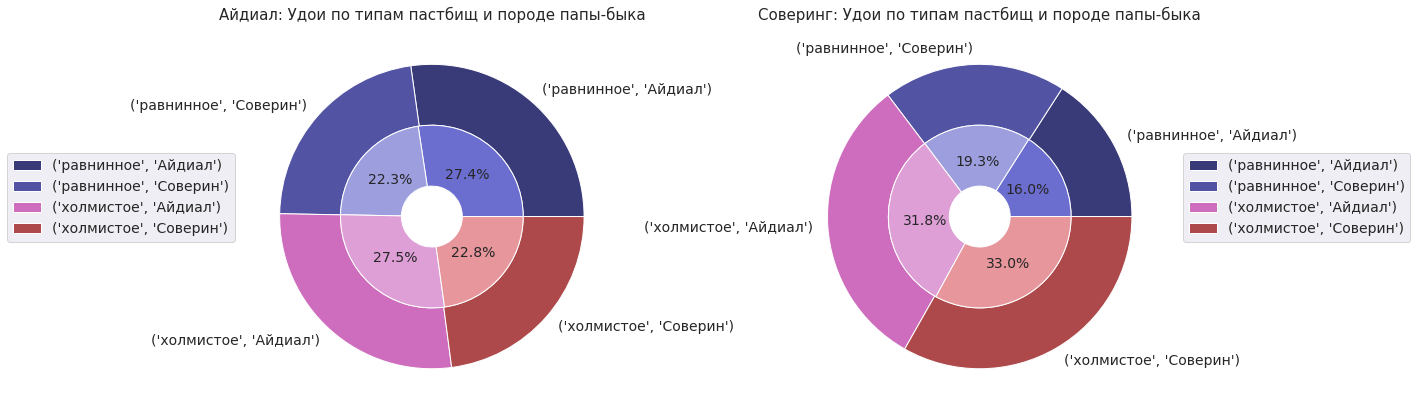

In [306]:
# Посмотрим удои в разбивке по типам пастбищ и породы папы-быка

fig, axs = plt.subplots(1, 2, figsize=(18, 7))

pv_ideal = df_ideal.pivot_table(index=['pasture', 'father_breed'], aggfunc=('sum'))
pv_sover = df_sovering.pivot_table(index=['pasture', 'father_breed'], aggfunc=('sum'))

cmap = plt.get_cmap('tab20b')
b_colors = cmap(np.array([0, 1, 18, 13]))
sm_colors = cmap(np.array([2, 3, 19, 15]))

font_size = 14

axs[0].pie(pv_ideal.sum(axis=1), radius=1, labels = pv_ideal.index, colors = b_colors,\
           wedgeprops=dict(width=0.4, edgecolor='w'), textprops={'fontsize': font_size})
axs[0].pie(pv_ideal['milk_yield'], radius=1-0.4,  colors = sm_colors,\
           wedgeprops=dict(width=0.4, edgecolor='w'), autopct='%1.1f%%', textprops={'fontsize': font_size})
axs[0].set_title('Айдиал: Удои по типам пастбищ и породе папы-быка', fontsize=15)
axs[0].legend(bbox_to_anchor=[0.0, 0.55], loc='center right', fontsize=14);

axs[1].pie(pv_sover.sum(axis=1), radius=1, labels = pv_sover.index, colors = b_colors,\
           wedgeprops=dict(width=0.4, edgecolor='w'), textprops={'fontsize': font_size})
axs[1].pie(pv_sover['milk_yield'], radius=1-0.4,  colors = sm_colors,\
           wedgeprops=dict(width=0.4, edgecolor='w'), autopct='%1.1f%%', textprops={'fontsize': font_size})
axs[1].set_title('Соверинг: Удои по типам пастбищ и породе папы-быка', fontsize=15)
axs[1].legend(bbox_to_anchor=[1.65, 0.55], loc='center right', fontsize=14);

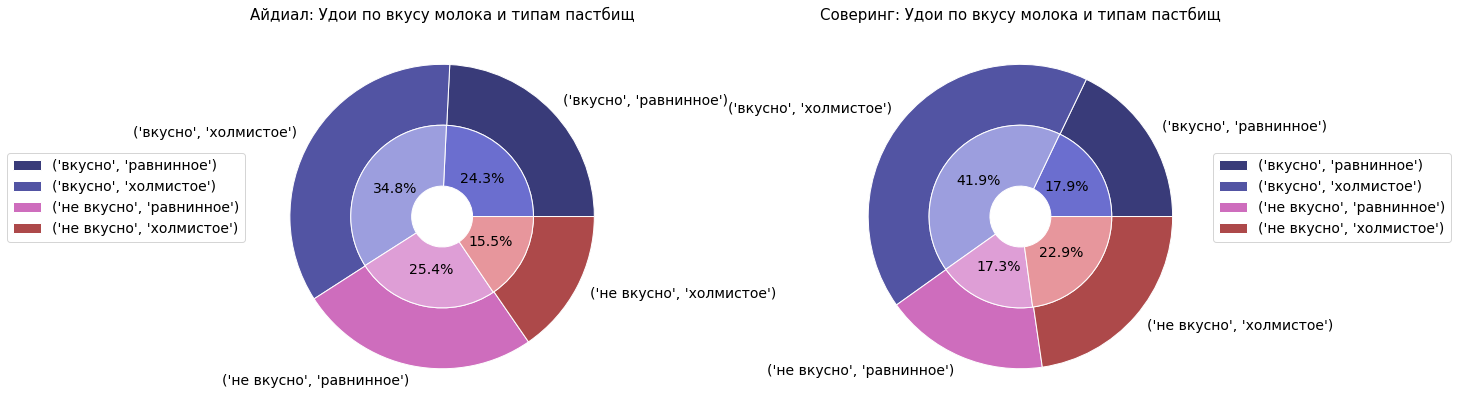

In [137]:
# Посмотрим вкус молока в разбивке по вкусу молока и типам пастбищ

fig, axs = plt.subplots(1, 2, figsize=(19, 7))

pvm_ideal = df_ideal.pivot_table(index=['taste','pasture'], aggfunc=('sum'))
pvm_sover = df_sovering.pivot_table(index=['taste','pasture'], aggfunc=('sum'))

cmap = plt.get_cmap('tab20b')
b_colors = cmap(np.array([0, 1, 18, 13]))
sm_colors = cmap(np.array([2, 3, 19, 15]))

font_size = 14

axs[0].pie(pvm_ideal.sum(axis=1), radius=1, labels = pvm_ideal.index, colors = b_colors,\
           wedgeprops=dict(width=0.4, edgecolor='w'), textprops={'fontsize': font_size})
axs[0].pie(pvm_ideal['milk_yield'], radius=1-0.4,  colors = sm_colors,\
           wedgeprops=dict(width=0.4, edgecolor='w'), autopct='%1.1f%%', textprops={'fontsize': font_size})
axs[0].set_title('Айдиал: Удои по вкусу молока и типам пастбищ', fontsize=15)
axs[0].legend(bbox_to_anchor=[0.0, 0.55], loc='center right', fontsize=14);

axs[1].pie(pvm_sover.sum(axis=1), radius=1, labels = pvm_sover.index, colors = b_colors,\
           wedgeprops=dict(width=0.4, edgecolor='w'), textprops={'fontsize': font_size})
axs[1].pie(pvm_sover['milk_yield'], radius=1-0.4,  colors = sm_colors,\
           wedgeprops=dict(width=0.4, edgecolor='w'), autopct='%1.1f%%', textprops={'fontsize': font_size})
axs[1].set_title('Соверинг: Удои по вкусу молока и типам пастбищ', fontsize=15)
axs[1].legend(bbox_to_anchor=[1.65, 0.55], loc='center right', fontsize=14);

## Корреляционный анализ

Посмотрим на зависимости параметров

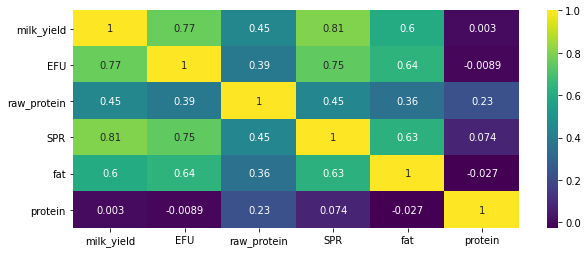

In [138]:
# Матрица корреляции для числовых признаков

fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(ferma_main[['milk_yield', 'EFU', 'raw_protein', 'SPR', 'breed', 'pasture',
       'father_breed', 'fat', 'protein', 'taste', 'age']].corr(), annot=True, cmap='viridis');

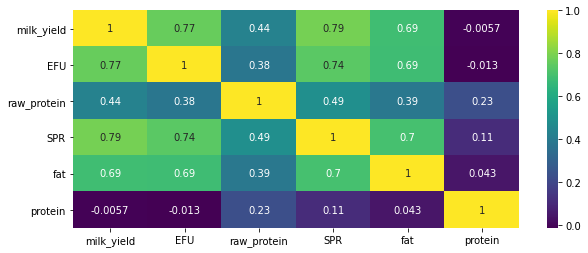

In [139]:
# Матрица корреляции для числовых признаков в целом для всего файла

fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(ferma_main[['milk_yield', 'EFU', 'raw_protein', 'SPR', 'breed', 'pasture',
       'father_breed', 'fat', 'protein', 'taste', 'age']].corr(method='spearman'), annot=True, cmap='viridis');

Есть высокая положительная зависимость между удоями и СПО (79%) и ЭКЕ (76%). И средняя - с уровнем сырого протеина в корме.
Уровень сырого протеина в меньшей степени коррелирует с удоями.

Показатели жирности и белка в молоке - это факторы не влияющие на удои, а скорее их следствие - характеристики готового продукта. Но взаимосвязь с удоями у показателя жирности молока довольно высокая (68%)

interval columns not set, guessing: ['milk_yield', 'EFU', 'raw_protein', 'SPR', 'fat', 'protein']


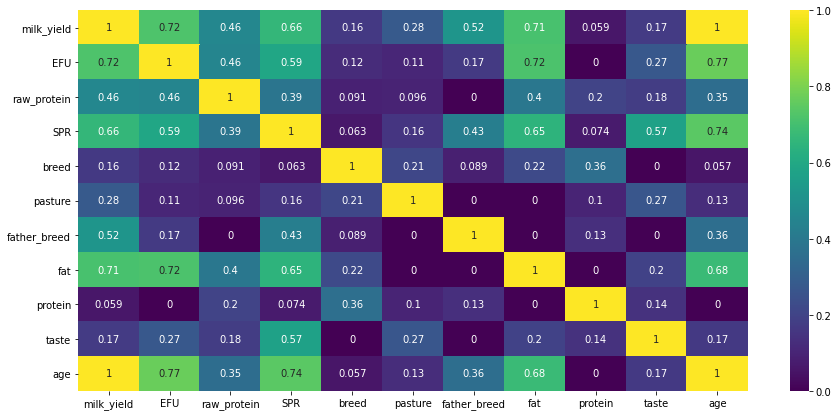

In [140]:
# Матрица корреляции Фи в целом для всех данных

fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(ferma_main.drop(['id'], axis=1).phik_matrix(), annot=True, cmap='viridis');

Зависимость удоев и возраста составляет 100%.

Затем по степени вляиния на удои идут: ЭКЕ, СПО, порода папы-быка. Ниже 50% взаимосвязь показателей: уровень белка в корме, тип пастбища и порода коровы.

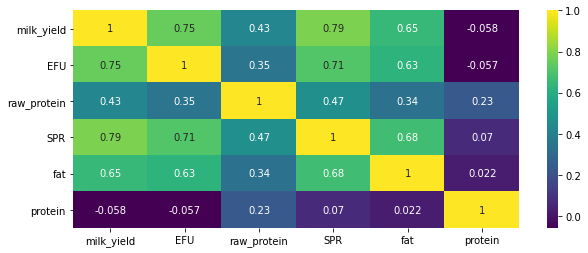

In [141]:
# Матрица корреляции для числовых признаков вкусного молока

fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(
    ferma_main.query(
        'taste == "вкусно"'
    )[['milk_yield', 'EFU', 'raw_protein', 'SPR', 'breed', 'pasture', 'father_breed', 'fat', 'protein', 'taste', 'age']].corr(
        method='spearman'
    ), annot=True, cmap='viridis'
);

У вкусного молока из числовых признаков наибольшая корреляция с СПО (79%), ЭКЕ (74%), Жирность молока (68%) и на среднем уровне - сырой протеин в корме (42%). С показателем белка молока корреляция ничтожная отрицательная.

interval columns not set, guessing: ['milk_yield', 'EFU', 'raw_protein', 'SPR', 'fat', 'protein']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable taste for analysis 1. Dropping this column
  warnings.warn(


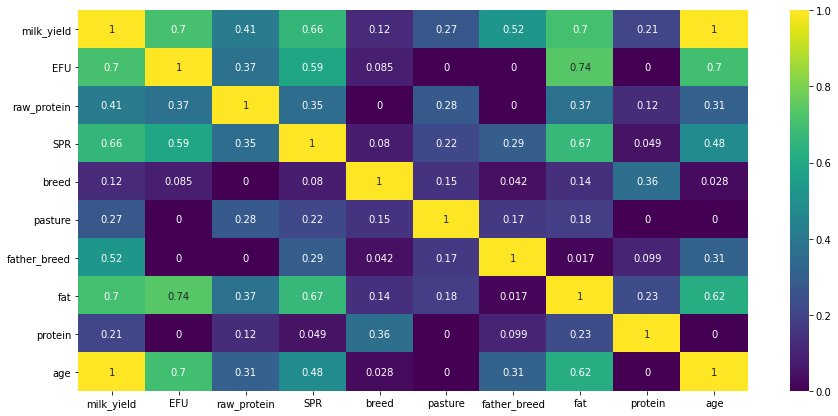

In [142]:
# Матрица корреляции Фи в целом для вкусного молока

fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(ferma_main[ferma_main['taste'] == "вкусно"].drop(['id'], axis=1).phik_matrix(), annot=True, cmap='viridis');

Интересно, что про учете всех признаков, кореляция вкусного молока с удоями есть только у ЭКЕ и уровня жирности молока.

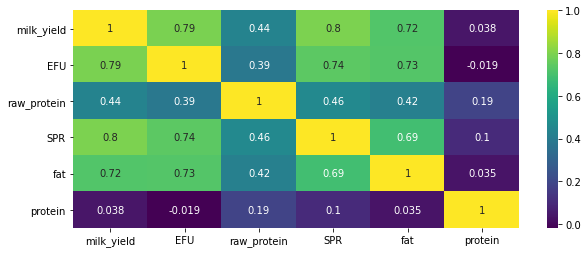

In [143]:
# Матрица корреляции для числовых признаков вкусного молока

fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(
    ferma_main.query(
        'taste == "не вкусно"'
    )[['milk_yield', 'EFU', 'raw_protein', 'SPR', 'breed', 'pasture', 'father_breed', 'fat', 'protein', 'taste', 'age']].corr(
        method='spearman'
    ), annot=True, cmap='viridis'
);

У НЕ вкусного молока из числовых признаков наибольшая корреляция с СПО (80%), ЭКЕ (79%), Жирность молока (72%) и на среднем уровне - сырой протеин в корме (44%). С показателем белка полока корреляция ничтожная положительная.

interval columns not set, guessing: ['milk_yield', 'EFU', 'raw_protein', 'SPR', 'fat', 'protein']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable taste for analysis 1. Dropping this column
  warnings.warn(


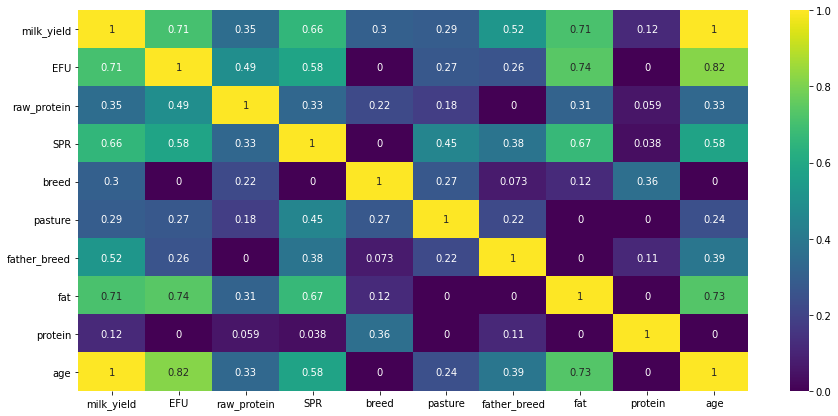

In [144]:
# Матрица корреляции Фи в целом для вкусного молока

fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(ferma_main[ferma_main['taste'] == "не вкусно"].drop(['id'], axis=1).phik_matrix(), annot=True, cmap='viridis');

А вот у НЕ вскусного молока гораздо больше корреляций: жирность (72%), ЭКЕ (71%), СПО (66%), порода папы-быка (52%). И ниже среднего уровня: сырой протеин в корме (35%), порода коровы и тип пастбища (по 29%). и даже уровень белка в молоке (12%).

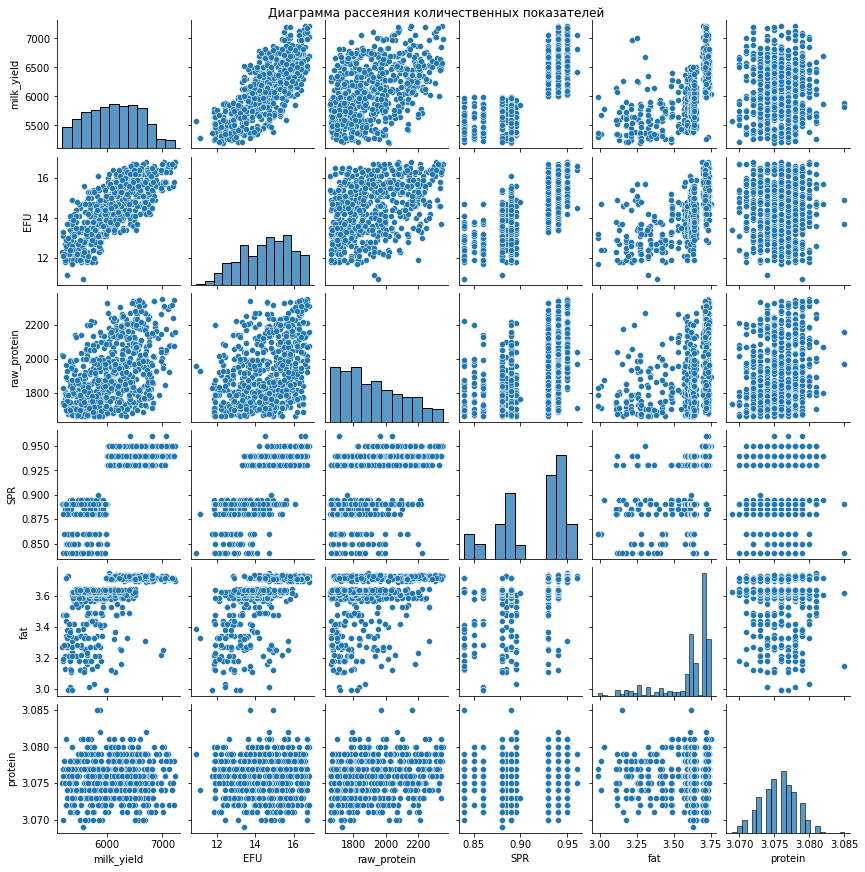

In [145]:
# Диаграмма рассеяния количественных показателей

sns.pairplot(ferma_main[['milk_yield', 'EFU', 'raw_protein', 'SPR', 'fat', 'protein']]).fig.suptitle('Диаграмма рассеяния количественных показателей', y=1)
plt.gcf().set_size_inches(12,12);

Здесь также мы видим некоторую линейную зависимоть у удоев и уровня сырого протеина, а также ЭКЕ.

Рассмотрим показатели отдельно.

In [146]:
# сделала функцию, но она не работает, а время дорого. поэтому я ее использовать не буду

def scatter_feature(df, x, y, feature):
    groups = df.groupby('feature')
    plt.figure(figsize=(16,4))
    for name, group in groups:
        plt.plot(group.x, group.y, marker='o', linestyle='', label=name)
        plt.legend();   

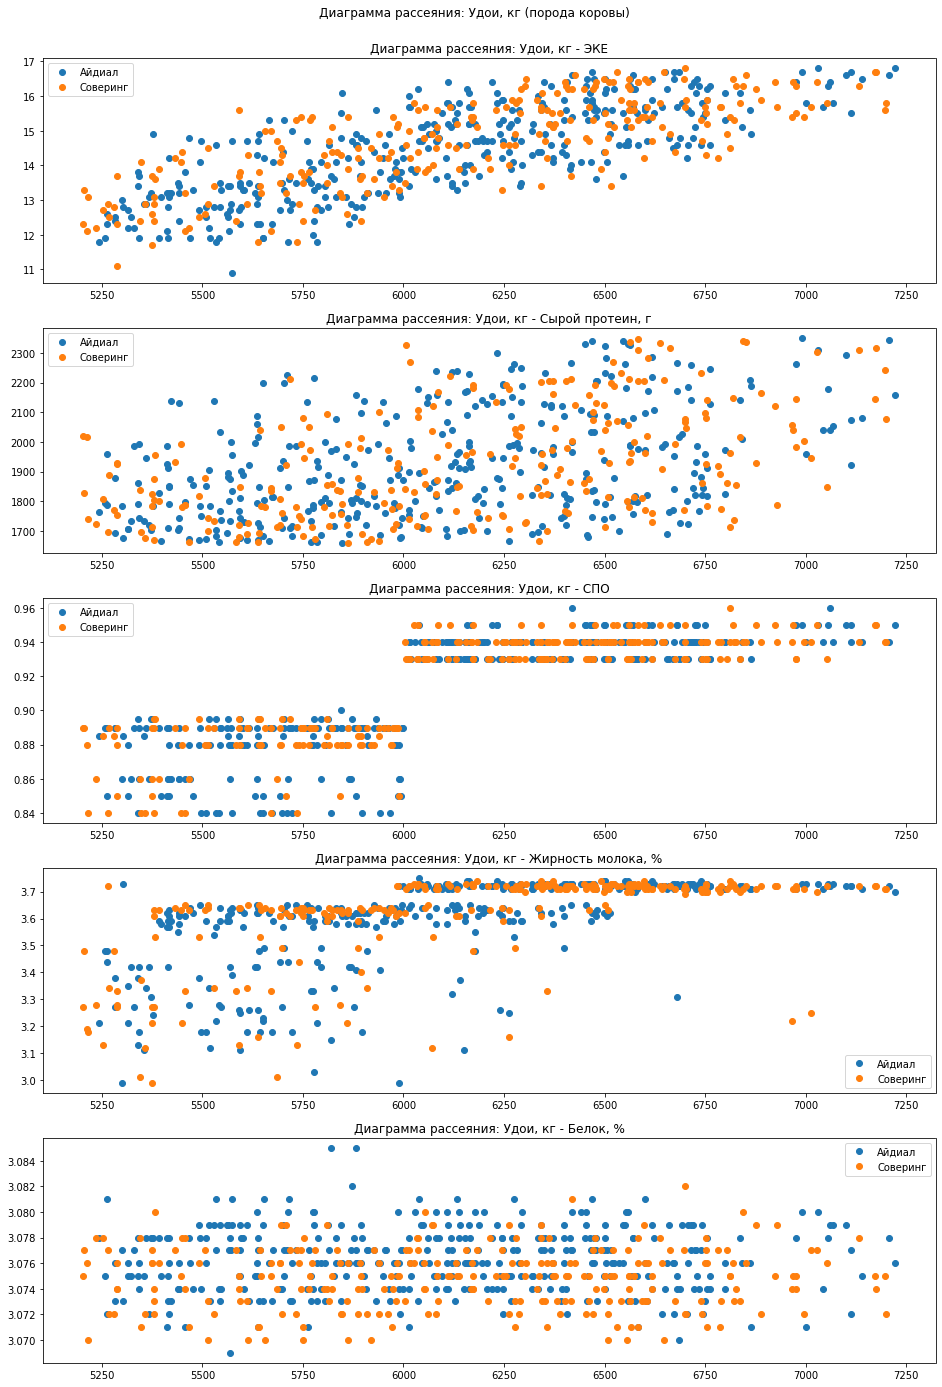

In [147]:
# Рассмотрим взаимосвязь Удоев и других количественных признаков с разбивкой по породам коров

fig, axs = plt.subplots(5, 1, figsize=(16,24))

plt.suptitle('Диаграмма рассеяния: Удои, кг (порода коровы)', y=0.91)

groups = ferma_main.groupby('breed')

for name, group in groups:
    axs[0].plot(group.milk_yield, group.EFU, marker='o', linestyle='', label=name)
    axs[0].set_title("Диаграмма рассеяния: Удои, кг - ЭКЕ")
    axs[0].legend();

for name, group in groups:
    axs[1].plot(group.milk_yield, group.raw_protein, marker='o', linestyle='', label=name)
    axs[1].set_title("Диаграмма рассеяния: Удои, кг - Сырой протеин, г")
    axs[1].legend();

for name, group in groups:
    axs[2].plot(group.milk_yield, group.SPR, marker='o', linestyle='', label=name)
    axs[2].set_title("Диаграмма рассеяния: Удои, кг - СПО")
    axs[2].legend();    

for name, group in groups:
    axs[3].plot(group.milk_yield, group.fat	, marker='o', linestyle='', label=name)
    axs[3].set_title("Диаграмма рассеяния: Удои, кг - Жирность молока, %")
    axs[3].legend();
    
for name, group in groups:
    axs[4].plot(group.milk_yield, group.protein, marker='o', linestyle='', label=name)
    axs[4].set_title("Диаграмма рассеяния: Удои, кг - Белок, %")
    axs[4].legend();    

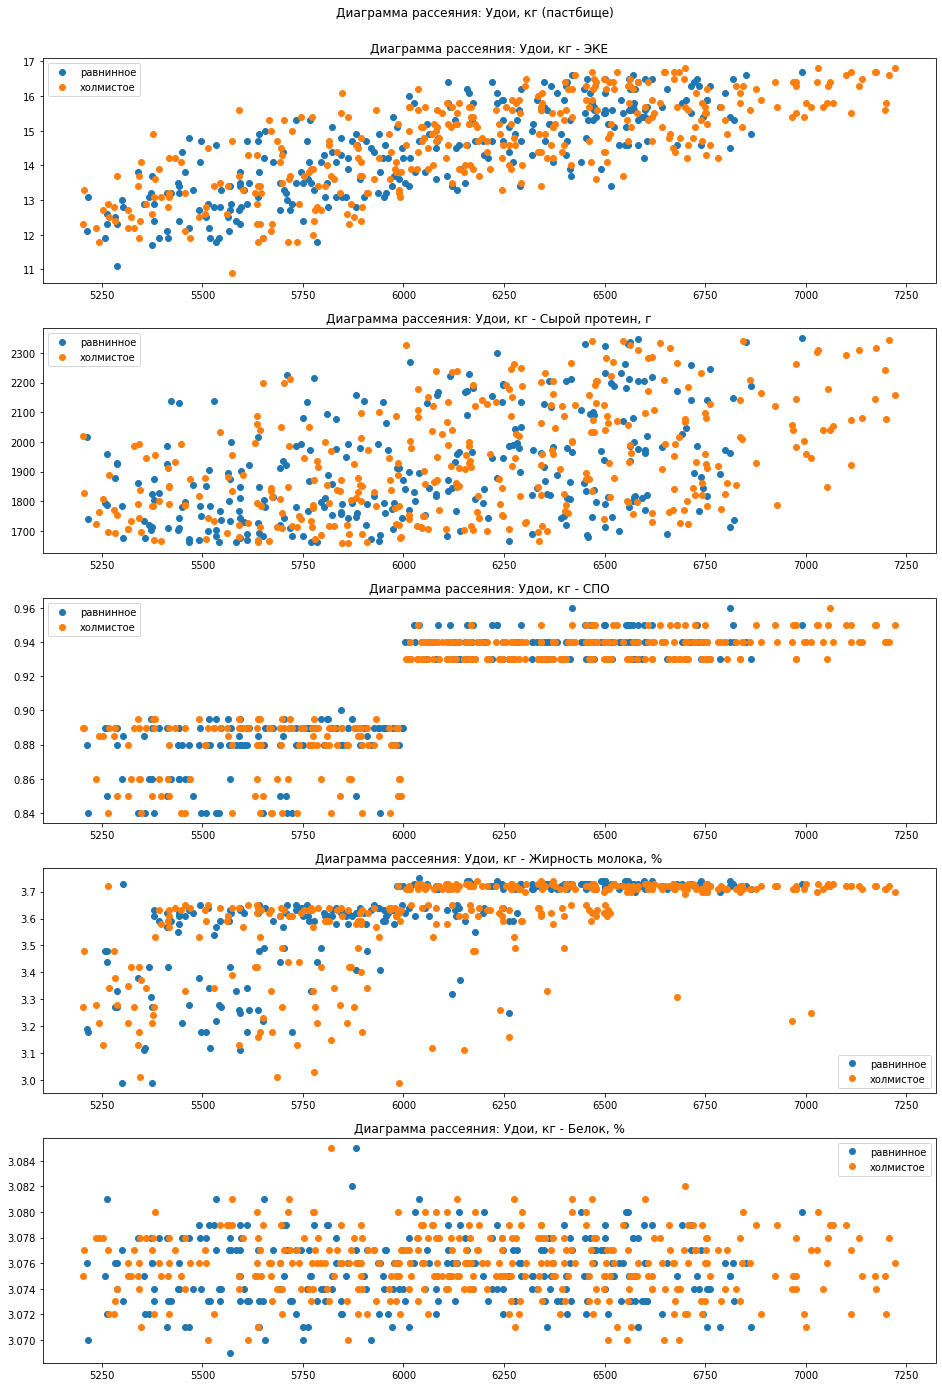

In [148]:
# Рассмотрим взаимосвязь Удоев и других количественных признаков с разбивкой по типам пастбищ

fig, axs = plt.subplots(5, 1, figsize=(16,24))

plt.suptitle('Диаграмма рассеяния: Удои, кг (пастбище)', y=0.91)

groups = ferma_main.groupby('pasture')

for name, group in groups:
    axs[0].plot(group.milk_yield, group.EFU, marker='o', linestyle='', label=name)
    axs[0].set_title("Диаграмма рассеяния: Удои, кг - ЭКЕ")
    axs[0].legend();

for name, group in groups:
    axs[1].plot(group.milk_yield, group.raw_protein, marker='o', linestyle='', label=name)
    axs[1].set_title("Диаграмма рассеяния: Удои, кг - Сырой протеин, г")
    axs[1].legend();

for name, group in groups:
    axs[2].plot(group.milk_yield, group.SPR, marker='o', linestyle='', label=name)
    axs[2].set_title("Диаграмма рассеяния: Удои, кг - СПО")
    axs[2].legend();    

for name, group in groups:
    axs[3].plot(group.milk_yield, group.fat	, marker='o', linestyle='', label=name)
    axs[3].set_title("Диаграмма рассеяния: Удои, кг - Жирность молока, %")
    axs[3].legend();
    
for name, group in groups:
    axs[4].plot(group.milk_yield, group.protein, marker='o', linestyle='', label=name)
    axs[4].set_title("Диаграмма рассеяния: Удои, кг - Белок, %")
    axs[4].legend();    

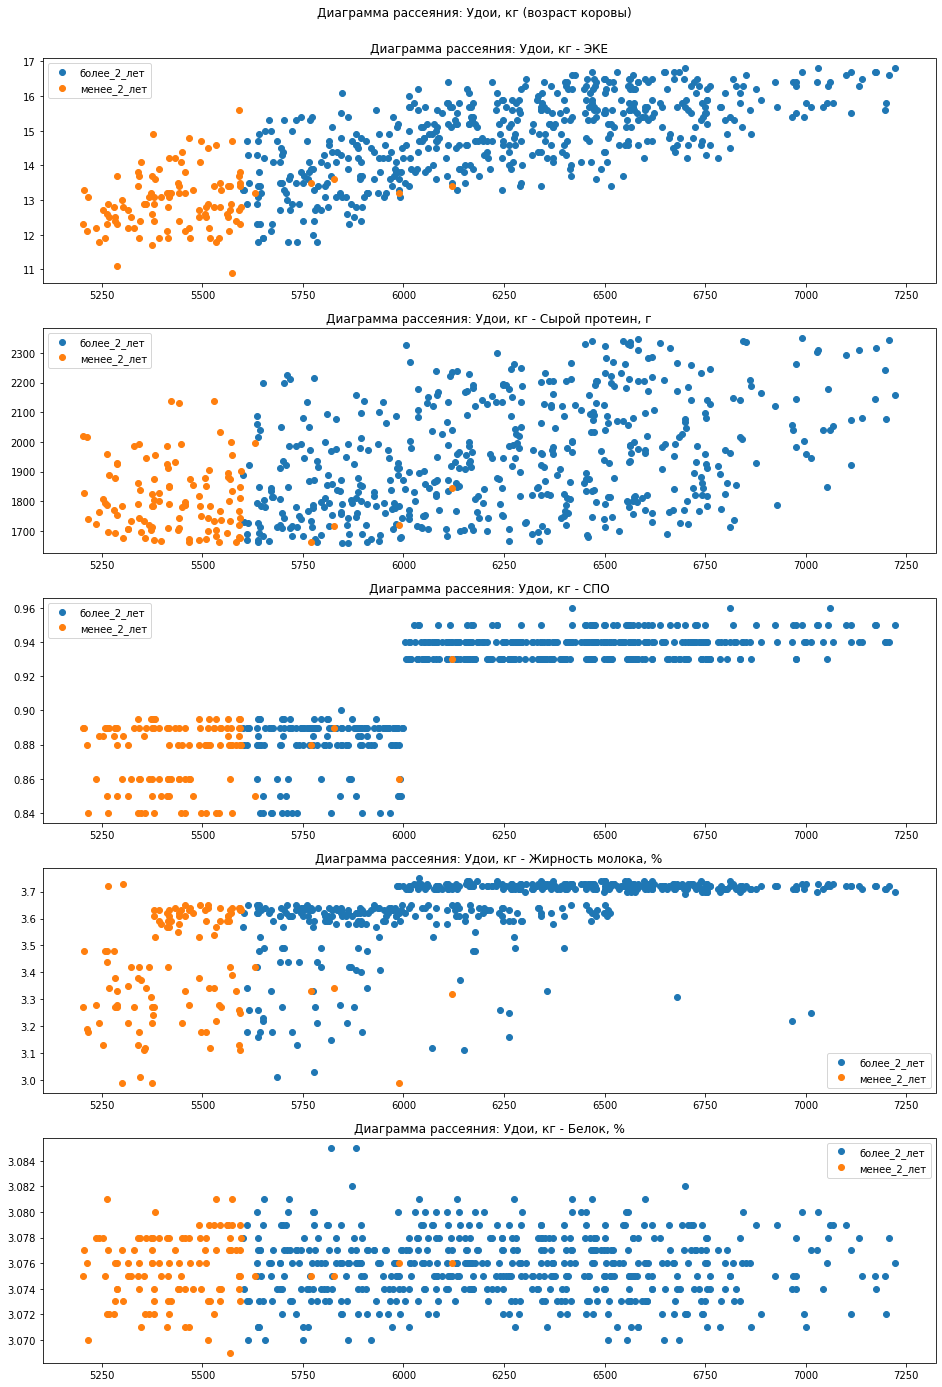

In [149]:
# Рассмотрим взаимосвязь Удоев и других количественных признаков с разбивкой по возрасту коров

fig, axs = plt.subplots(5, 1, figsize=(16,24))

plt.suptitle('Диаграмма рассеяния: Удои, кг (возраст коровы)', y=0.91)

groups = ferma_main.groupby('age')

for name, group in groups:
    axs[0].plot(group.milk_yield, group.EFU, marker='o', linestyle='', label=name)
    axs[0].set_title("Диаграмма рассеяния: Удои, кг - ЭКЕ")
    axs[0].legend();

for name, group in groups:
    axs[1].plot(group.milk_yield, group.raw_protein, marker='o', linestyle='', label=name)
    axs[1].set_title("Диаграмма рассеяния: Удои, кг - Сырой протеин, г")
    axs[1].legend();

for name, group in groups:
    axs[2].plot(group.milk_yield, group.SPR, marker='o', linestyle='', label=name)
    axs[2].set_title("Диаграмма рассеяния: Удои, кг - СПО")
    axs[2].legend();    

for name, group in groups:
    axs[3].plot(group.milk_yield, group.fat	, marker='o', linestyle='', label=name)
    axs[3].set_title("Диаграмма рассеяния: Удои, кг - Жирность молока, %")
    axs[3].legend();
    
for name, group in groups:
    axs[4].plot(group.milk_yield, group.protein, marker='o', linestyle='', label=name)
    axs[4].set_title("Диаграмма рассеяния: Удои, кг - Белок, %")
    axs[4].legend();    

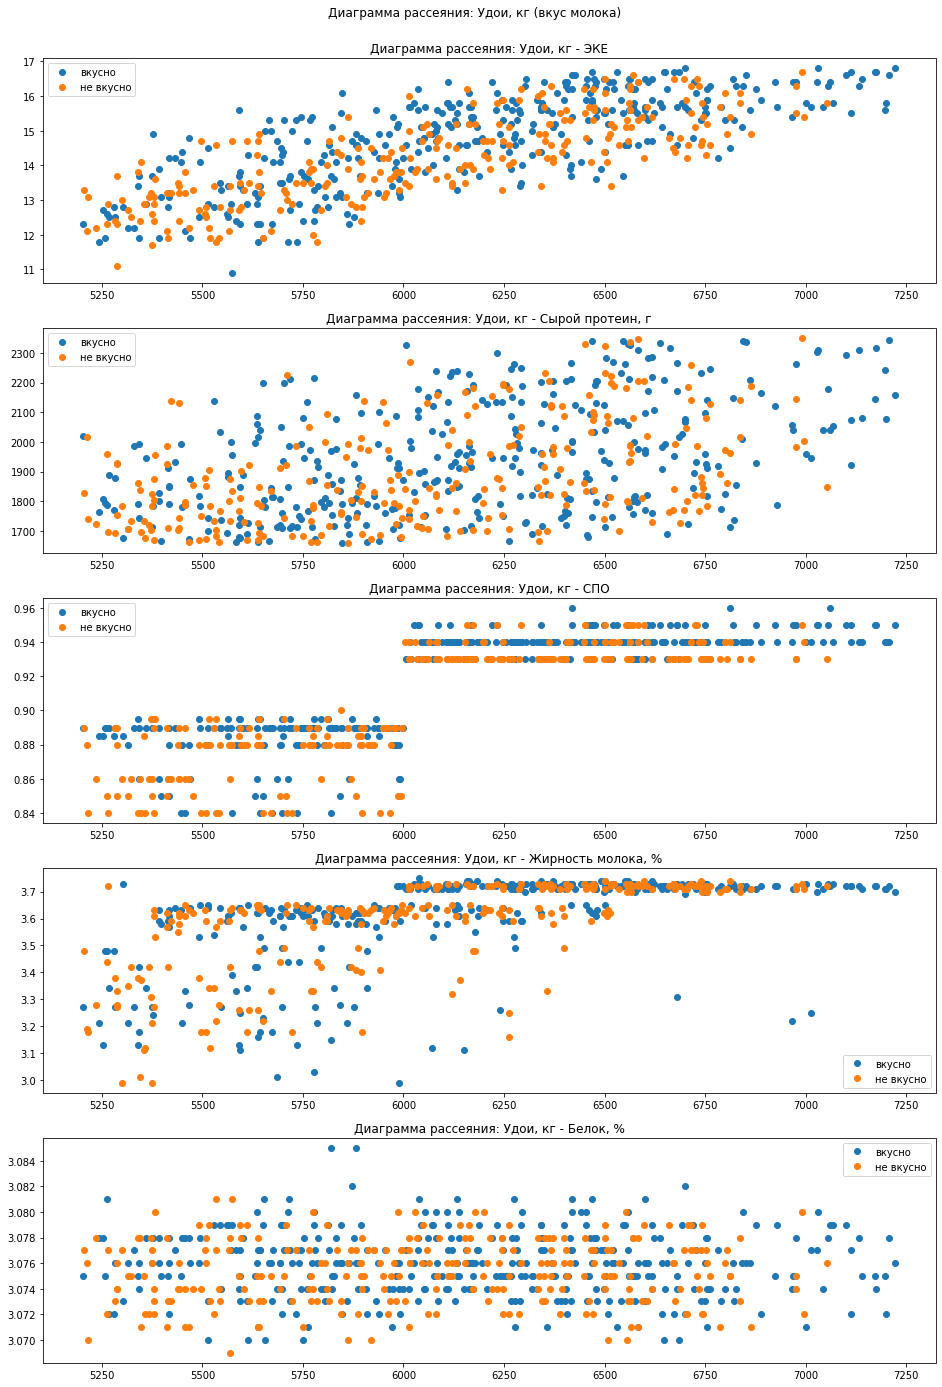

In [150]:
# Рассмотрим взаимосвязь Удоев и других количественных признаков с разбивкой по вкусу молока

fig, axs = plt.subplots(5, 1, figsize=(16,24))

plt.suptitle('Диаграмма рассеяния: Удои, кг (вкус молока)', y=0.91)

groups = ferma_main.groupby('taste')

for name, group in groups:
    axs[0].plot(group.milk_yield, group.EFU, marker='o', linestyle='', label=name)
    axs[0].set_title("Диаграмма рассеяния: Удои, кг - ЭКЕ")
    axs[0].legend();

for name, group in groups:
    axs[1].plot(group.milk_yield, group.raw_protein, marker='o', linestyle='', label=name)
    axs[1].set_title("Диаграмма рассеяния: Удои, кг - Сырой протеин, г")
    axs[1].legend();

for name, group in groups:
    axs[2].plot(group.milk_yield, group.SPR, marker='o', linestyle='', label=name)
    axs[2].set_title("Диаграмма рассеяния: Удои, кг - СПО")
    axs[2].legend();    

for name, group in groups:
    axs[3].plot(group.milk_yield, group.fat	, marker='o', linestyle='', label=name)
    axs[3].set_title("Диаграмма рассеяния: Удои, кг - Жирность молока, %")
    axs[3].legend();
    
for name, group in groups:
    axs[4].plot(group.milk_yield, group.protein, marker='o', linestyle='', label=name)
    axs[4].set_title("Диаграмма рассеяния: Удои, кг - Белок, %")
    axs[4].legend();   

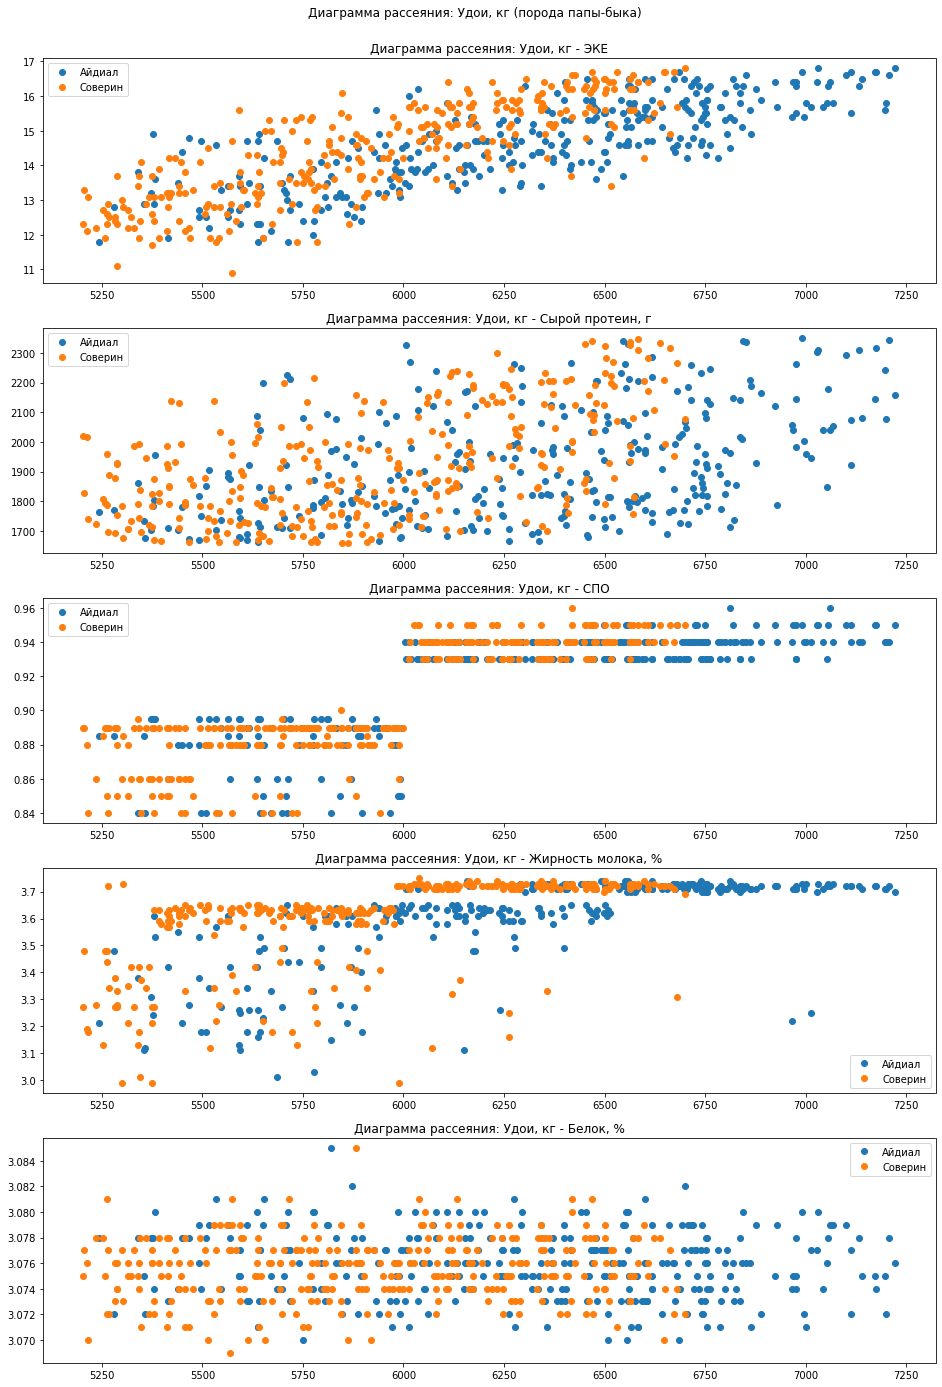

In [151]:
# Рассмотрим взаимосвязь Удоев и других количественных признаков с разбивкой по породе папы-быка

fig, axs = plt.subplots(5, 1, figsize=(16,24))

plt.suptitle('Диаграмма рассеяния: Удои, кг (порода папы-быка)', y=0.91)

groups = ferma_main.groupby('father_breed')

for name, group in groups:
    axs[0].plot(group.milk_yield, group.EFU, marker='o', linestyle='', label=name)
    axs[0].set_title("Диаграмма рассеяния: Удои, кг - ЭКЕ")
    axs[0].legend();

for name, group in groups:
    axs[1].plot(group.milk_yield, group.raw_protein, marker='o', linestyle='', label=name)
    axs[1].set_title("Диаграмма рассеяния: Удои, кг - Сырой протеин, г")
    axs[1].legend();

for name, group in groups:
    axs[2].plot(group.milk_yield, group.SPR, marker='o', linestyle='', label=name)
    axs[2].set_title("Диаграмма рассеяния: Удои, кг - СПО")
    axs[2].legend();    

for name, group in groups:
    axs[3].plot(group.milk_yield, group.fat	, marker='o', linestyle='', label=name)
    axs[3].set_title("Диаграмма рассеяния: Удои, кг - Жирность молока, %")
    axs[3].legend();
    
for name, group in groups:
    axs[4].plot(group.milk_yield, group.protein, marker='o', linestyle='', label=name)
    axs[4].set_title("Диаграмма рассеяния: Удои, кг - Белок, %")
    axs[4].legend(); 

Не могу сказать, что характер взаимосвязей стал более четким. 

Можно отметить, что у коров старше 2-х лет более высокие удои, и соотв. все остальные числовые параметры. 
У коров происходящих от быков породы "Айдиал" показатели удоев выше, чем у коров, происходящих от быков породы "Соверинг".
Показатель вкуса не имеет четкой зависимости от каких либо признаков. Видимо, это крайне субъективная оценка фермера. 
Наиболее высокие удои наблюдаются у коров, выпасающихся на хомистых пастбищах, нежели на равнинных.
У коров породы "Айдиал" более высокие показатели белка в молоке. 

Также, стоит обратить внимание на четко выделяющиеся 2 группы по параметрам Жирность молока и СПО. При удоях до 6000 кг, Жирность молока и особенно СПО значительно ниже,  чем при удоях от 6000 кг и выше.

Если построить матрицу корреляции числовых признаков по каждой породе, то:

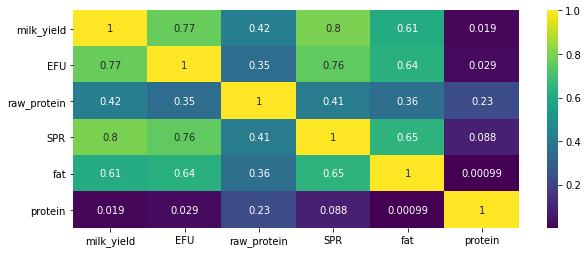

In [152]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(ferma_main.query('breed == "Айдиал"').drop(['id'], axis=1).corr(), annot=True, cmap='viridis');

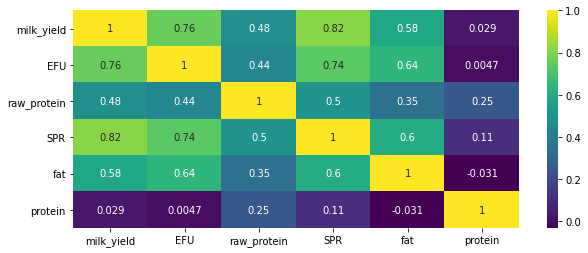

In [153]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(ferma_main.query('breed == "Соверинг"').drop(['id'], axis=1).corr(), annot=True, cmap='viridis');

..ситуация кардинально не изменится. 

Можно попробовать добавить имя папы-быка.

In [154]:
# Добавим имя папы-быка

ferma_main = ferma_main.merge(ferma_dad, on='id', how='left')

In [155]:
# Проверим, что получилось

ferma_main.head()

id  milk_yield   EFU  raw_protein    SPR     breed    pasture father_breed  \
0   1        5863  14.2         1743  0.890    Айдиал  равнинное       Айдиал   
1   2        5529  12.8         2138  0.890    Айдиал  равнинное      Соверин   
2   3        5810  14.0         1854  0.885  Соверинг  холмистое      Соверин   
3   4        5895  12.4         2012  0.885  Соверинг  холмистое       Айдиал   
4   5        5302  12.8         1675  0.885    Айдиал  равнинное      Соверин   

    fat  protein      taste          age father_name  
0  3.58    3.076     вкусно  более_2_лет      Буйный  
1  3.54    3.079     вкусно  менее_2_лет    Соловчик  
2  3.59    3.074  не вкусно  более_2_лет       Барин  
3  3.40    3.075  не вкусно  более_2_лет      Буйный  
4  3.73    3.073     вкусно  менее_2_лет       Барин

In [156]:
# Проверим количество строк и столбцов в файле

ferma_main.shape

(628, 13)

Все в порядке, добавилась новая колонка.

In [157]:
# На всякий случай проверим дубликаты

ferma_main.duplicated().sum()

0

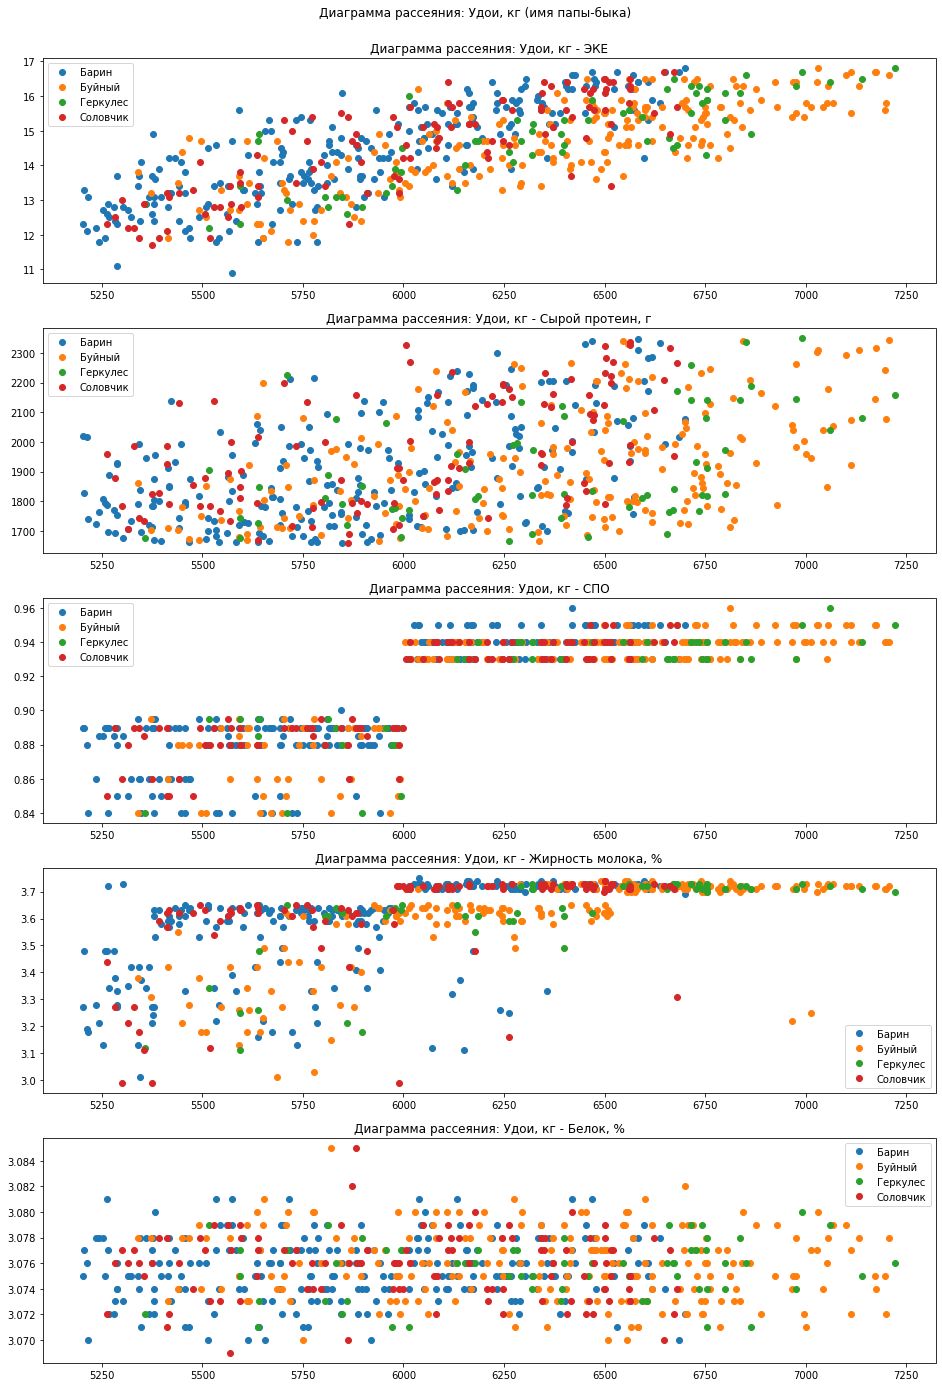

In [158]:
# Рассмотрим взаимосвязь Удоев и других количественных признаков с разбивкой по имени папы-быка

fig, axs = plt.subplots(5, 1, figsize=(16,24))

plt.suptitle('Диаграмма рассеяния: Удои, кг (имя папы-быка)', y=0.91)

groups = ferma_main.groupby('father_name')

for name, group in groups:
    axs[0].plot(group.milk_yield, group.EFU, marker='o', linestyle='', label=name)
    axs[0].set_title("Диаграмма рассеяния: Удои, кг - ЭКЕ")
    axs[0].legend();

for name, group in groups:
    axs[1].plot(group.milk_yield, group.raw_protein, marker='o', linestyle='', label=name)
    axs[1].set_title("Диаграмма рассеяния: Удои, кг - Сырой протеин, г")
    axs[1].legend();

for name, group in groups:
    axs[2].plot(group.milk_yield, group.SPR, marker='o', linestyle='', label=name)
    axs[2].set_title("Диаграмма рассеяния: Удои, кг - СПО")
    axs[2].legend();    

for name, group in groups:
    axs[3].plot(group.milk_yield, group.fat	, marker='o', linestyle='', label=name)
    axs[3].set_title("Диаграмма рассеяния: Удои, кг - Жирность молока, %")
    axs[3].legend();
    
for name, group in groups:
    axs[4].plot(group.milk_yield, group.protein, marker='o', linestyle='', label=name)
    axs[4].set_title("Диаграмма рассеяния: Удои, кг - Белок, %")
    axs[4].legend();   

Более высокие удои у коров, происходящих от быков "Буйный" и "Геркулес". И меньшие удои у коров, происходящих от быков "Соловчик" и "Барин". 

interval columns not set, guessing: ['milk_yield', 'EFU', 'raw_protein', 'SPR', 'fat', 'protein']


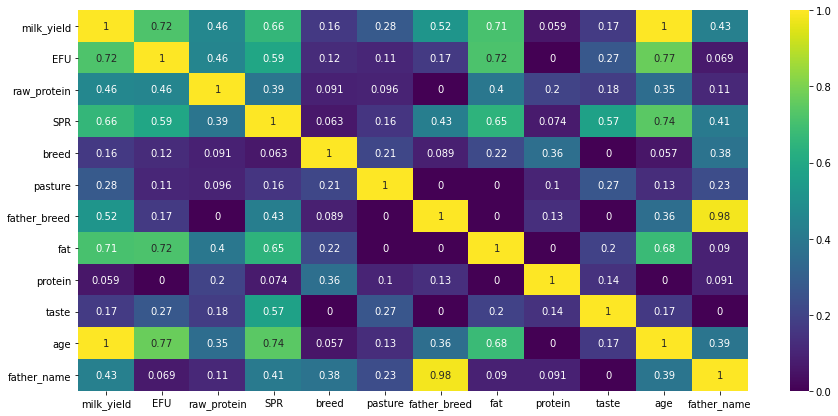

In [159]:
# Рассмотрим коэффициенты корреляции Фи с учетом нового признака

fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(ferma_main[['milk_yield', 'EFU', 'raw_protein', 'SPR', 'breed', 'pasture',
       'father_breed', 'fat', 'protein', 'taste', 'age', 'father_name']].phik_matrix(), annot=True, cmap='viridis');

Мультиколлинеарность в данном датасете между входящими признаками появляется только при добавлении имени папы-быка (взаимосвязь с породой папы).

interval columns not set, guessing: ['milk_yield', 'EFU', 'raw_protein', 'SPR']


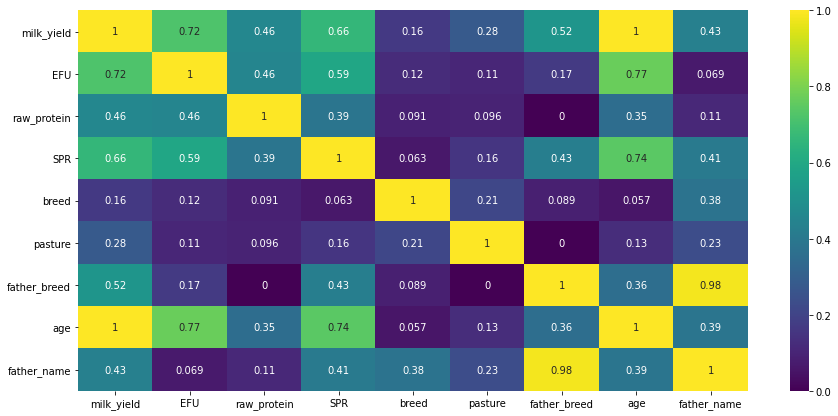

In [160]:
# Если убрать признаки молока:

fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(ferma_main.drop(['id', 'taste', 'fat', 'protein'], axis=1).phik_matrix(), annot=True, cmap='viridis');

Имя папы-быка влияет на удои чуть меньше, чем порода папы-быка.

**Вывод:**

Составлена матрица корреляций Спирмана (числовые признаки) и Фи (все признаки, включая категориальные).
Изначально мультиколлинеарность не выявлена (нет корреляции между входными признаками от 0,9 и выше).
* 100% корреляция удоев с возрастом коровы. 
* Корреляция удоев с СПО и ЭКЕ довольно высокая, но вполне линейная. 
* На диаграммах рассеяния у коров, происходящих от папы-быка породы Айдиал удои выше.

Отмечена высокая корреляция с жирностью молока (0,71), однако на уровень удоев этот показатель никак не влияет и не рассматривается в модели линейной регрессии.

На Диаграммах рассеяния можно отметить особенность параметра СПО - данные разделяются на уровне 6 000 кг удоев или 0,91 СПО на 2 группыю По жирности молока картина похожа, но граница не такая четкая, и скорее 3 группы.

Диаграммы рассеяния показывают взаимосвзяь удоев и типа пастбищ: на холмистых пастбищах удои выше. 

При добавлении в выборку имени папы-быка у него возникает коллинеарность с породой папы-быка.
Тем не менее, коровы, происходящие от быков Буйный и Геркулес показывают более высокие удои, нежели происходящие отбыков Солвчик и Барин.

Признак имя папы-быка временно удален из основного датасета, чтобы обучить первую модель на исходных данных.

## Обучение модели линейной регрессии

Удалим пока имя папы из дата сета.

In [161]:
ferma_main = ferma_main.drop(['father_name'], axis=1)

In [162]:
ferma_main.shape

(628, 12)

### Обучение модели линейной регрессии №1

In [163]:
# Отберем целевой и входящие признаки из выборки

X = ferma_main.drop('milk_yield', axis=1)
y = ferma_main['milk_yield']

In [164]:
# Разобьем выборку на тренировочную и тестовую

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

Проверим размерность полученных выборок

In [165]:
# Размер тренировочной выборки

X_train.shape

(471, 11)

In [166]:
# Размер тестовой выборки

X_test.shape

(157, 11)

Разделение 3:1, как и планировалось.

Для входных признаков возьмем те, которые могут влиять на удои: признаки коровы, корма и пастбища.

In [167]:
# Создадим списки категориальных и количественных признаков

cat_col_names = ['age', 'breed', 'father_breed', 'pasture']
num_col_names = ['EFU', 'SPR', 'raw_protein']

In [168]:
# Подготовим признаки для машинного обучения
# Кодирование

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

# Получение имен колонок

encoder_col_names = encoder.get_feature_names()

In [169]:
# Масштабирование данных

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [170]:
def MML(df, target, cat_col_names, num_col_names):
    X = df.drop('target', axis=1)
    y = df['target']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)
    
    encoder = OneHotEncoder(drop='first', sparse=False)
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_test_ohe = encoder.transform(X_test[cat_col_names])
    
    encoder_col_names = encoder.get_feature_names()
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])
    
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
    
    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
    
    return X_train, X_test

In [171]:
# Создание дата-фрейма с новыми данными

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [172]:
# Обучение модели и получение предсказаний на тестовых данных

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
predictions = model_lr.predict(X_test)

In [173]:
# Расчет остатков

residuals = y_test - predictions

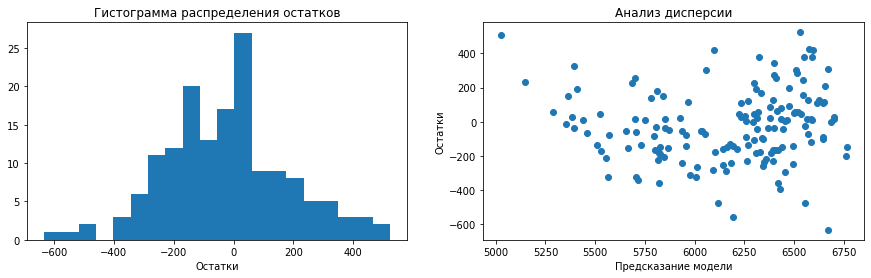

In [174]:
# Анализ остатков: графики по количественным признакам гистограмма и boxplot

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

axes[0].hist(residuals, bins=20)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказание модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

plt.show();

Гистограмма распределения остатков выглядит похоже на нормальное со смещением влево, те предсказывает более высокие удои, чем есть на самом деле. Но большая часть остатков - это 0 при выбранных параметрах.
Дисперсия, довольно-таки хаотична. (можно дорисовать линий и получится дисперсия типа "бегущая лошадь"). Но до постоянства дисперсии тут далеко, конечно. А это означает, что модель можно улучшить.

Добавим оценку нормальности распределения остатков

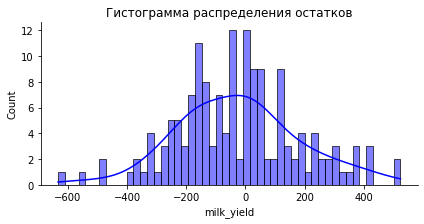

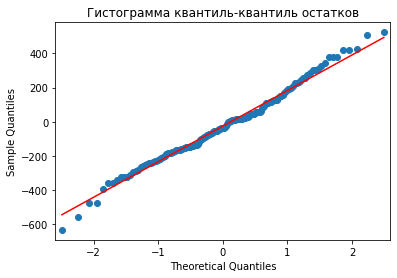

In [175]:
# Гистограмма распределения белка в молоке

sns.displot(residuals, color='blue',label='residuals', bins=50, kde=True, height=3, aspect=2)
plt.title(f'Гистограмма распределения остатков')
plt.show();

# График квантиль-квантиль

qqplot(residuals, line='s')
plt.title(f'Гистограмма квантиль-квантиль остатков')
plt.show;

Посчитаем метрики, для оценки качества модели

In [176]:
# MSE & RMSE 

mse_1 = mean_squared_error(y_test,  predictions)
rmse_1 = mean_squared_error(y_test,  predictions, squared=False)

display(mse_1, rmse_1)

43887.01500966054

209.4922791170609

В среднем предсказание модели отличается на 209 кг. Я бы сказала, что довольно большое отклонение, при среднем удое около 6100 кг ~ 3%. 

In [177]:
# MAE

mae_1 = mean_absolute_error(y_test,  predictions)
mae_1

164.2419446347494

При минимизации учета выбросов, точность модели выше.

Эти метрики пригодятся в дальнейшем для оценки качества модели при настройке.

In [178]:
# Коэффициент детерминации R2

r2_1 = r2_score(y_test,  predictions)
r2_1

0.7844078173416966

В 78% случаев предсказание модели ближе к истине, чем среднее значение целевого признака. Скажем, есть куда стремиться нашей модели.

### Обучение модели линейной регрессии №2

Добавим новый категориальный признак по значению СПО: при удое до 6000кг - низкое, от 6000кг - высокое. По признаку СПО граница находится на уровне 0,91. Обозначим значения ниже 0,91, как 0, выше - как 1.

In [179]:
# Создадим функцию

def cat_SPR(row):
    SPR = row['SPR']
    if SPR <= 0.91:
        return 0
    if 0.91 < SPR:
        return 1

In [180]:
# Применим функцию

ferma_main['SPR_cat'] = ferma_main.apply(cat_SPR, axis=1)

In [181]:
# Проверим, что данные появились

ferma_main.head()

id  milk_yield   EFU  raw_protein    SPR     breed    pasture father_breed  \
0   1        5863  14.2         1743  0.890    Айдиал  равнинное       Айдиал   
1   2        5529  12.8         2138  0.890    Айдиал  равнинное      Соверин   
2   3        5810  14.0         1854  0.885  Соверинг  холмистое      Соверин   
3   4        5895  12.4         2012  0.885  Соверинг  холмистое       Айдиал   
4   5        5302  12.8         1675  0.885    Айдиал  равнинное      Соверин   

    fat  protein      taste          age  SPR_cat  
0  3.58    3.076     вкусно  более_2_лет        0  
1  3.54    3.079     вкусно  менее_2_лет        0  
2  3.59    3.074  не вкусно  более_2_лет        0  
3  3.40    3.075  не вкусно  более_2_лет        0  
4  3.73    3.073     вкусно  менее_2_лет        0

In [182]:
# Проверим размер таблицы

ferma_main.shape

(628, 13)

Добавим новый признак - ЭКЕ в квадрате

In [183]:
ferma_main['EFU_2'] = ferma_main['EFU']**2

In [184]:
ferma_main.head()

id  milk_yield   EFU  raw_protein    SPR     breed    pasture father_breed  \
0   1        5863  14.2         1743  0.890    Айдиал  равнинное       Айдиал   
1   2        5529  12.8         2138  0.890    Айдиал  равнинное      Соверин   
2   3        5810  14.0         1854  0.885  Соверинг  холмистое      Соверин   
3   4        5895  12.4         2012  0.885  Соверинг  холмистое       Айдиал   
4   5        5302  12.8         1675  0.885    Айдиал  равнинное      Соверин   

    fat  protein      taste          age  SPR_cat   EFU_2  
0  3.58    3.076     вкусно  более_2_лет        0  201.64  
1  3.54    3.079     вкусно  менее_2_лет        0  163.84  
2  3.59    3.074  не вкусно  более_2_лет        0  196.00  
3  3.40    3.075  не вкусно  более_2_лет        0  153.76  
4  3.73    3.073     вкусно  менее_2_лет        0  163.84

In [185]:
ferma_main.shape

(628, 14)

interval columns not set, guessing: ['milk_yield', 'EFU', 'raw_protein', 'SPR', 'SPR_cat', 'EFU_2']


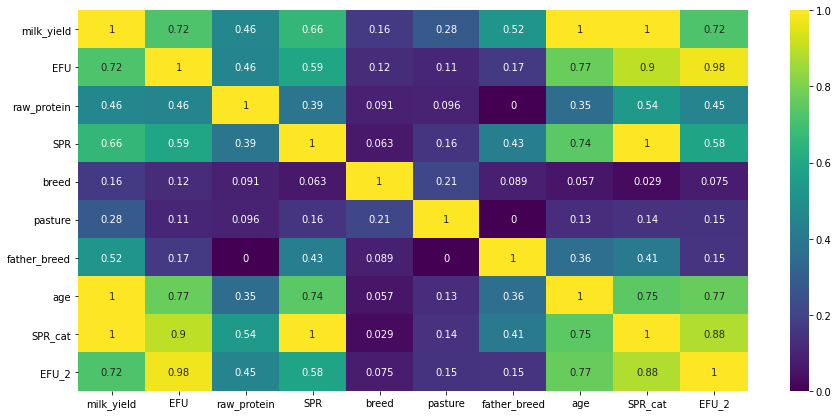

In [186]:
# Рассмотрим коэффициенты корреляции Фи с учетом новых признаков

fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(ferma_main.drop(['id', 'fat', 'taste', 'protein'], axis=1).phik_matrix(), annot=True, cmap='viridis');

СПО категориальный показывает 100% зависимость с удоями. 

Уровень влияния показателя ЭКЕ в квадрате не изменился.
Поскольку появилась мультиколлинеарность - признаки EFU и категория EFU_2 и SPR_cat - SPR, уберем исходные СПО и ЭКЕ.

Посмотрим, как работает модель с новыми признаками

Посмотрим, что получится с этой моделью

In [187]:
# Отберем целевой и входящие признаки из выборки

X = ferma_main.drop(['milk_yield', 'SPR', 'EFU'], axis=1)
y = ferma_main['milk_yield']

In [188]:
# Разобьем выборку на тренировочную и тестовую

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [189]:
# Создадим списки категориальных и количественных признаков

cat_col_names = ['age', 'breed', 'father_breed', 'pasture', 'SPR_cat']
num_col_names = ['EFU_2', 'raw_protein']

In [190]:
# Подготовим признаки для машинного обучения
# Кодирование

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

In [191]:
# Получение имен колонок

encoder_col_names = encoder.get_feature_names()

In [192]:
# Масштабирование данных

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [193]:
# Создание дата-фрейма с новыми данными

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [194]:
# Обучение модели и получение предсказаний на тестовых данных

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
predictions = model_lr.predict(X_test)

In [195]:
# Расчет остатков

residuals = y_test - predictions

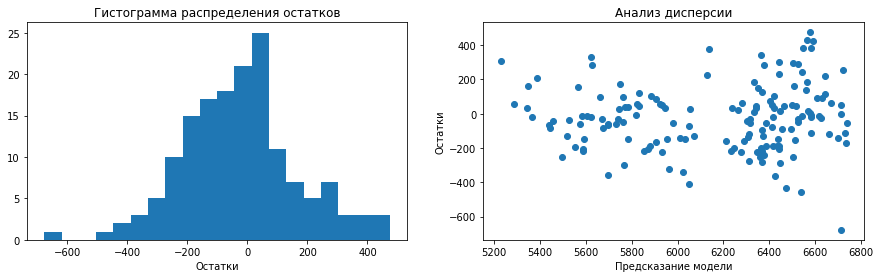

In [196]:
# Анализ остатков: графики по количественным признакам гистограмма и boxplot

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

axes[0].hist(residuals, bins=20)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказание модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

plt.show();

Распределение остатков стало более равномерным (при визуаьной оценке).

Можно оценить равномерность распределения остатков

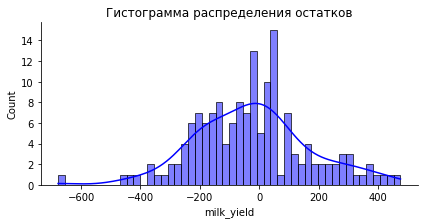

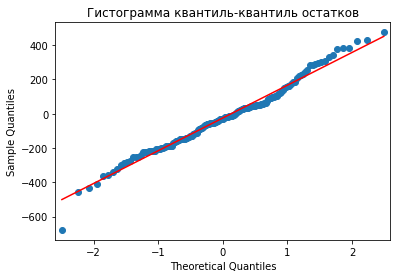

In [197]:
# Гистограмма распределения белка в молоке

sns.displot(residuals, color='blue',label='residuals', bins=50, kde=True, height=3, aspect=2)
plt.title(f'Гистограмма распределения остатков')
plt.show();

# График квантиль-квантиль

qqplot(residuals, line='s')
plt.title(f'Гистограмма квантиль-квантиль остатков')
plt.show;

In [198]:
# Посчитаем коэффициент асиметрии

residuals.skew()

0.09567343635925071

In [199]:
# Рассчитаем тест Андерсона

anderson(residuals)

AndersonResult(statistic=0.653818162098645, critical_values=array([0.562, 0.64 , 0.768, 0.896, 1.066]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

При уровне статистической значимости в 10% рассчитанная статистика превышает критическое значение. Похоже на нормальное распределение.

Посчитаем метрики, для оценки качества модели

In [200]:
# MSE & RMSE 

mse_2 = mean_squared_error(y_test,  predictions)
rmse_2 = mean_squared_error(y_test,  predictions, squared=False)

display(mse_2, rmse_2)

37030.91131113694

192.4341739690145

Предсказание модели несколь улучшилось.

In [201]:
# MAE

mae_2 = mean_absolute_error(y_test,  predictions)
mae_2

149.03965222364604

А если не учитывать выбросы, то хорошо улучшилось

In [202]:
# Коэффициент детерминации R2

r2_2 = r2_score(y_test,  predictions)
r2_2

0.8180879926867503

Коэффициент показывает, что этот вариант лучше предыдущего.

### Обучение модели линейной регрессии №3

Добавим имя папы-быка

In [203]:
ferma_main = ferma_main.merge(ferma_dad, on = 'id', how='left')

In [204]:
ferma_main.head()

id  milk_yield   EFU  raw_protein    SPR     breed    pasture father_breed  \
0   1        5863  14.2         1743  0.890    Айдиал  равнинное       Айдиал   
1   2        5529  12.8         2138  0.890    Айдиал  равнинное      Соверин   
2   3        5810  14.0         1854  0.885  Соверинг  холмистое      Соверин   
3   4        5895  12.4         2012  0.885  Соверинг  холмистое       Айдиал   
4   5        5302  12.8         1675  0.885    Айдиал  равнинное      Соверин   

    fat  protein      taste          age  SPR_cat   EFU_2 father_name  
0  3.58    3.076     вкусно  более_2_лет        0  201.64      Буйный  
1  3.54    3.079     вкусно  менее_2_лет        0  163.84    Соловчик  
2  3.59    3.074  не вкусно  более_2_лет        0  196.00       Барин  
3  3.40    3.075  не вкусно  более_2_лет        0  153.76      Буйный  
4  3.73    3.073     вкусно  менее_2_лет        0  163.84       Барин

In [205]:
ferma_main.shape

(628, 15)

interval columns not set, guessing: ['milk_yield', 'raw_protein', 'SPR_cat', 'EFU_2']


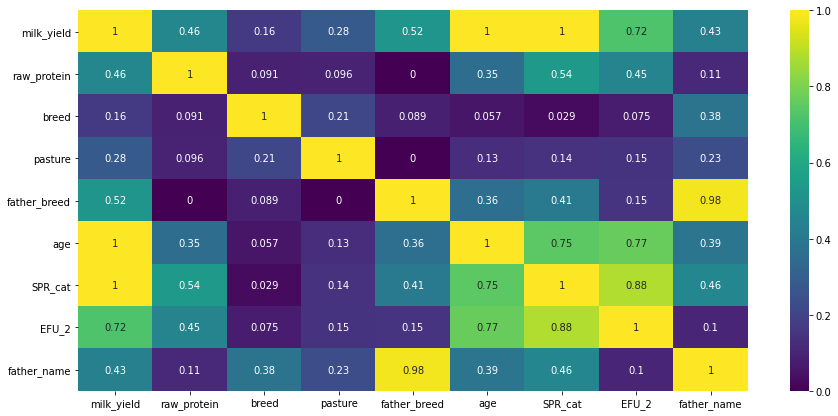

In [206]:
# Рассмотрим коэффициенты корреляции Фи с учетом новых признаков

fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(ferma_main.drop(['id', 'fat', 'protein', 'taste', 'EFU', 'SPR'], axis=1).phik_matrix(), annot=True, cmap='viridis');

Имя папы-быка и порода папы-быка создают мультиколлинеарность, поэтому породу пока исключим из модели.

Создадим 3ю модель.

In [207]:
# Отберем целевой и входящие признаки из выборки

X = ferma_main.drop(['milk_yield', 'SPR', 'EFU', 'father_breed'], axis=1)
y = ferma_main['milk_yield']

In [208]:
# Разобьем выборку на тренировочную и тестовую

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [209]:
# Создадим списки категориальных и количественных признаков

cat_col_names = ['age', 'breed', 'father_name', 'pasture']
num_col_names = ['EFU_2', 'raw_protein', 'SPR_cat']

In [210]:
# Подготовим признаки для машинного обучения
# Кодирование

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

In [211]:
# Получение имен колонок

encoder_col_names = encoder.get_feature_names()

In [212]:
# Масштабирование данных

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [213]:
# Создание дата-фрейма с новыми данными

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [214]:
# Обучение модели и получение предсказаний на тестовых данных

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
predictions = model_lr.predict(X_test)

In [215]:
# Расчет остатков

residuals = y_test - predictions

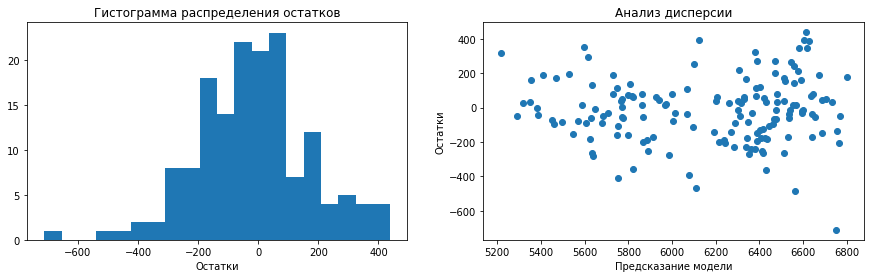

In [216]:
# Анализ остатков: графики по количественным признакам гистограмма и boxplot

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

axes[0].hist(residuals, bins=20)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказание модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

plt.show();

In [217]:
# Выведем описание остатков

residuals.describe()

count    157.000000
mean     -17.118513
std      187.743088
min     -711.976902
25%     -139.478141
50%      -15.817371
75%       76.820483
max      438.780151
Name: milk_yield, dtype: float64

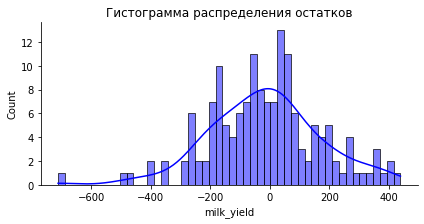

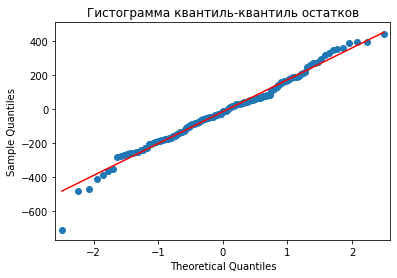

In [218]:
# Оценим равномерность распределения остатков
# Гистограмма распределения белка в молоке

sns.displot(residuals, color='blue',label='residuals', bins=50, kde=True, height=3, aspect=2)
plt.title(f'Гистограмма распределения остатков')
plt.show();

# График квантиль-квантиль

qqplot(residuals, line='s')
plt.title(f'Гистограмма квантиль-квантиль остатков')
plt.show;

In [219]:
# Посчитаем коэффициент асиметрии

residuals.skew()

-0.17270725796454955

In [220]:
# Рассчитаем тест Андерсона

anderson(residuals)

AndersonResult(statistic=0.4694517568987635, critical_values=array([0.562, 0.64 , 0.768, 0.896, 1.066]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Остатки распределены более равномерно

In [221]:
# MSE & RMSE 

mse_3 = mean_squared_error(y_test,  predictions)
rmse_3 = mean_squared_error(y_test,  predictions, squared=False)

display(mse_3, rmse_3)

35316.00436000989

187.9255287607564

In [222]:
# MAE

mae_3 = mean_absolute_error(y_test,  predictions)
mae_3

144.6381370452687

In [223]:
# Коэффициент детерминации R2

r2_3 = r2_score(y_test,  predictions)
r2_3

0.8265123645098964

Эта модель выглядит получше по всем метрикам. В 82% случаев предсказание модели ближе к истине, чем среднее значение целевого признака. Среднее отклонение предсказанного признака также снизилось.

Сравним метрики 3х моделей

In [224]:
columns = ['model_1', 'model_2', 'model_3']
index = ['mse', 'rmse', 'mae', 'r2']
data = [[mse_1, mse_2, mse_3], [rmse_1, rmse_2, rmse_3], [mae_1, mae_2, mae_3], [r2_1, r2_2, r2_3]]
metrics_lr = pd.DataFrame(data=data, index=index, columns=columns)

In [225]:
metrics_lr

model_1       model_2       model_3
mse   43887.015010  37030.911311  35316.004360
rmse    209.492279    192.434174    187.925529
mae     164.241945    149.039652    144.638137
r2        0.784408      0.818088      0.826512

Третья модель получилась наиболее удачной, судя по метрикам.

In [226]:
# Доверительный интервал 3-й модели

st.t.interval(confidence=0.95, df=len(predictions)-1, loc=np.mean(predictions), scale=st.sem(predictions)) 

(6094.10183044554, 6223.447297001353)

Существует вероятность 95%, что доверительный интервал (6091.35, 6220.77) содержит истинный поазатель удоев, кг.

In [227]:
ferma_main['milk_yield'].describe()

count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: milk_yield, dtype: float64

### Прогноз удоя коров по модели линейной регрессии

Добавим в базу данных cow покзатели EFU, raw_protein, SPR - из средних значений таблицы ferma_main, увеличенных на 5%.

In [228]:
# создадим вспомогательные колонки

ferma_main['key'] = ferma_main[['breed', 'pasture', 'father_breed','age']].agg(''. join, axis=1)
cow['key'] = cow[['breed', 'pasture', 'father_breed','age']].agg(''. join, axis=1)

In [229]:
# Добавим данные

for item in cow['key'].unique():
    cow['EFU'] = ferma_main.query('key==@item')['EFU'].mean()*1.05
    cow['raw_protein'] = ferma_main.query('key==@item')['raw_protein'].mean()*1.05
    cow['SPR'] = ferma_main.query('key==@item')['SPR'].mean()*1.05

In [230]:
# Посмотрим, что получилось

cow.head()

breed    pasture father_breed father_name   fat  protein          age  \
0    Айдиал  холмистое       Айдиал    Геркулес  3.58    3.076  более_2_лет   
1    Айдиал  равнинное      Соверин      Буйный  3.54    3.081  менее_2_лет   
2  Соверинг  равнинное      Соверин       Барин  3.59    3.074  более_2_лет   
3  Соверинг  холмистое       Айдиал      Буйный  3.40    3.061  более_2_лет   
4  Соверинг  равнинное       Айдиал      Буйный  3.64    3.074  более_2_лет   

                                   key     EFU  raw_protein       SPR  
0     АйдиалхолмистоеАйдиалболее_2_лет  13.545  1911.365217  0.916467  
1    АйдиалравнинноеСоверинменее_2_лет  13.545  1911.365217  0.916467  
2  СоверингравнинноеСоверинболее_2_лет  13.545  1911.365217  0.916467  
3   СоверингхолмистоеАйдиалболее_2_лет  13.545  1911.365217  0.916467  
4   СоверингравнинноеАйдиалболее_2_лет  13.545  1911.365217  0.916467

In [231]:
cow.shape

(20, 11)

In [232]:
# Удалим вспомогательные колонки

ferma_main = ferma_main.drop(['key'], axis=1 )
cow = cow.drop(['key'], axis=1)

In [233]:
ferma_main.shape

(628, 15)

In [234]:
cow.shape

(20, 10)

In [235]:
cow['EFU_2'] = cow['EFU']**2

In [236]:
cow['SPR_cat'] = cow.apply(cat_SPR, axis=1)

In [237]:
cow.shape

(20, 12)

Проведем подготовку данных

In [238]:
data = cow

In [239]:
#Создадим списки категориальных и количественных признаков

cat_col_names = ['age', 'breed', 'father_name', 'pasture']
num_col_names = ['EFU_2', 'raw_protein', 'SPR_cat']

In [240]:
#Подготовим признаки для машинного обучения
#Кодирование

data_ohe = encoder.transform(data[cat_col_names])

In [241]:
#Получение имен колонок

encoder_col_names = encoder.get_feature_names()

In [242]:
#Масштабирование данных

data_scaled = scaler.transform(data[num_col_names])

In [243]:
#Создание дата-фрейма с новыми данными

data_ohe = pd.DataFrame(data_ohe, columns=encoder_col_names)
data_scaled = pd.DataFrame(data_scaled, columns=num_col_names)
data = pd.concat([data_ohe, data_scaled], axis=1)

In [244]:
# Получим предсказание модели для отобранных коров

predictions = model_lr.predict(data)

In [245]:
#predictions

In [246]:
# Добавим полученные предсказания в файл с отобранными коровами

cow['milk_yield'] = predictions.T

In [247]:
# Посмотрим, что получилось

cow.query('milk_yield >= 6000').sort_values(by='milk_yield', ascending = False)

breed    pasture father_breed father_name   fat  protein          age  \
0     Айдиал  холмистое       Айдиал    Геркулес  3.58    3.076  более_2_лет   
6     Айдиал  холмистое       Айдиал    Геркулес  3.58    3.076  более_2_лет   
12    Айдиал  холмистое       Айдиал    Геркулес  3.68    3.046  более_2_лет   
15  Соверинг  холмистое       Айдиал      Буйный  3.40    3.065  более_2_лет   
3   Соверинг  холмистое       Айдиал      Буйный  3.40    3.061  более_2_лет   
11  Соверинг  равнинное      Соверин    Геркулес  3.73    3.073  более_2_лет   
19  Соверинг  равнинное       Айдиал      Буйный  3.64    3.074  более_2_лет   
4   Соверинг  равнинное       Айдиал      Буйный  3.64    3.074  более_2_лет   
7     Айдиал  равнинное      Соверин      Буйный  3.57    3.079  более_2_лет   
18    Айдиал  равнинное      Соверин      Буйный  3.34    3.069  более_2_лет   
9   Соверинг  холмистое       Айдиал      Буйный  3.40    3.079  менее_2_лет   
5   Соверинг  равнинное      Соверин    Геркулес  3.63    3.053  менее_2_лет   
17  Соверинг  равнинное      Соверин    Геркулес  3.77    3.053  менее_2_лет   
10    Айдиал  холмистое      Соверин    Соловчик  3.73    3.055  более_2_лет   
16    Айдиал  холмистое      Соверин    Соловчик  3.73    3.079  более_2_лет   
1     Айдиал  равнинное      Соверин      Буйный  3.54    3.081  менее_2_лет   
8   Соверинг  равнинное      Соверин       Барин  3.59    3.074  более_2_лет   
14  Соверинг  равнинное      Соверин       Барин  3.59    3.074  более_2_лет   
2   Соверинг  равнинное      Соверин       Барин  3.59    3.074  более_2_лет   

       EFU  raw_protein       SPR       EFU_2  SPR_cat   milk_yield  
0   13.545  1911.365217  0.916467  183.467025        1  6361.827579  
6   13.545  1911.365217  0.916467  183.467025        1  6361.827579  
12  13.545  1911.365217  0.916467  183.467025        1  6361.827579  
15  13.545  1911.365217  0.916467  183.467025        1  6345.411838  
3   13.545  1911.365217  0.916467  183.467025        1  6345.411838  
11  13.545  1911.365217  0.916467  183.467025        1  6327.566763  
19  13.545  1911.365217  0.916467  183.467025        1  6296.412739  
4   13.545  1911.365217  0.916467  183.467025        1  6296.412739  
7   13.545  1911.365217  0.916467  183.467025        1  6281.674457  
18  13.545  1911.365217  0.916467  183.467025        1  6281.674457  
9   13.545  1911.365217  0.916467  183.467025        1  6151.396410  
5   13.545  1911.365217  0.916467  183.467025        1  6133.551334  
17  13.545  1911.365217  0.916467  183.467025        1  6133.551334  
10  13.545  1911.365217  0.916467  183.467025        1  6092.228115  
16  13.545  1911.365217  0.916467  183.467025        1  6092.228115  
1   13.545  1911.365217  0.916467  183.467025        1  6087.659028  
8   13.545  1911.365217  0.916467  183.467025        1  6034.524159  
14  13.545  1911.365217  0.916467  183.467025        1  6034.524159  
2   13.545  1911.365217  0.916467  183.467025        1  6034.524159

In [248]:
# Количество коров с удоем выше 6 000 кг

cow.query('milk_yield >= 6000')['breed'].count()

19

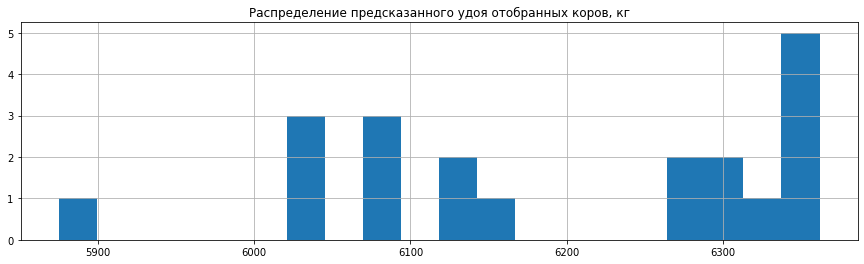

In [249]:
# И как выглядит распределение предсказанного удоя отобранных коров на гистограмме

cow['milk_yield'].hist(bins=20, figsize=(15,4)).set_title("Распределение предсказанного удоя отобранных коров, кг");

In [250]:
# Посмотрим на описание полученного признака.

cow['milk_yield'].describe().to_frame().T

count         mean         std          min          25%  \
milk_yield   20.0  6196.450196  145.777777  5874.769546  6091.085844   

                    50%          75%          max  
milk_yield  6216.535433  6332.028031  6361.827579

**Вывод:**

Обучены 3 модели линейной регрессии:
1. на исходных данных
2. с добавлением признака ЭКЕ в квадрате и категориального СПО
3. с добавлением признака имя папы-быка.

Во втором случае во избежание мультиколлинеарности исключены признаки СПО и ЭКЕ.
В третьем случае исключен признак порода папы-быка.

С учетом рассчитанных метрик, лушче всего себя показала 3я модель (показатель r2 = 0,82, по сравнению с 0,81 у 2й и 0,78 у 1й модели).

На основе третьей модели рассчитан прогноз удоев для отобранных коров. Срдений показатель предсказанного признак составил 6 129кг. при разбросе 25 - 75% от 6 023 до 6 264кг.

## Обучение модели логистической регрессии

Создадим колонку с признаком вкуса молока: 1 = молоко вкусное, 0 = молоко не вкусное

In [251]:
# Создадим функцию

def taste_cat(row):
    taste = row['taste']
    if taste == "не вкусно":
        return 0
    if taste == "вкусно":
        return 1

In [252]:
# Применим функцию

ferma_main['taste_cat'] = ferma_main.apply(taste_cat, axis=1)

In [253]:
# Создадим функцию

def fat_cat(row):
    fat_cat = row['fat']
    if fat_cat <= 3.66:
        return 0
    if fat_cat > 3.66:
        return 1

In [254]:
# Применим функцию

ferma_main['fat_cat'] = ferma_main.apply(fat_cat, axis=1)

In [255]:
# Добавим квадрат значений

ferma_main['raw_protein_2'] = ferma_main['raw_protein']**2
ferma_main['protein_2'] = ferma_main['protein']**2
ferma_main['fat_2'] = ferma_main['fat']**2

In [256]:
ferma_main.head()

id  milk_yield   EFU  raw_protein    SPR     breed    pasture father_breed  \
0   1        5863  14.2         1743  0.890    Айдиал  равнинное       Айдиал   
1   2        5529  12.8         2138  0.890    Айдиал  равнинное      Соверин   
2   3        5810  14.0         1854  0.885  Соверинг  холмистое      Соверин   
3   4        5895  12.4         2012  0.885  Соверинг  холмистое       Айдиал   
4   5        5302  12.8         1675  0.885    Айдиал  равнинное      Соверин   

    fat  protein      taste          age  SPR_cat   EFU_2 father_name  \
0  3.58    3.076     вкусно  более_2_лет        0  201.64      Буйный   
1  3.54    3.079     вкусно  менее_2_лет        0  163.84    Соловчик   
2  3.59    3.074  не вкусно  более_2_лет        0  196.00       Барин   
3  3.40    3.075  не вкусно  более_2_лет        0  153.76      Буйный   
4  3.73    3.073     вкусно  менее_2_лет        0  163.84       Барин   

   taste_cat  fat_cat  raw_protein_2  protein_2    fat_2  
0          1        0        3038049   9.461776  12.8164  
1          1        0        4571044   9.480241  12.5316  
2          0        0        3437316   9.449476  12.8881  
3          0        0        4048144   9.455625  11.5600  
4          1        1        2805625   9.443329  13.9129

In [257]:
ferma_main.shape

(628, 20)

Рассмотрим матрицу корреляций, с учетом признаков, влияющих на вкус молока.
Лишние признаки не будем учитывать.
Показатели порода коровы, порода папы-быка и имя папы-быка имеют 0-ю корреляцию. Показатель ЭКЕ ниже, чем Эке_2, между собой они мультиколлинеарны. Показатель СПО по категориям составляет 0,1, между тем он мультиколлинеарен с СПО. 

interval columns not set, guessing: ['taste_cat', 'SPR', 'SPR_cat', 'fat', 'fat_2', 'fat_cat', 'milk_yield', 'protein', 'protein_2', 'raw_protein', 'raw_protein_2']


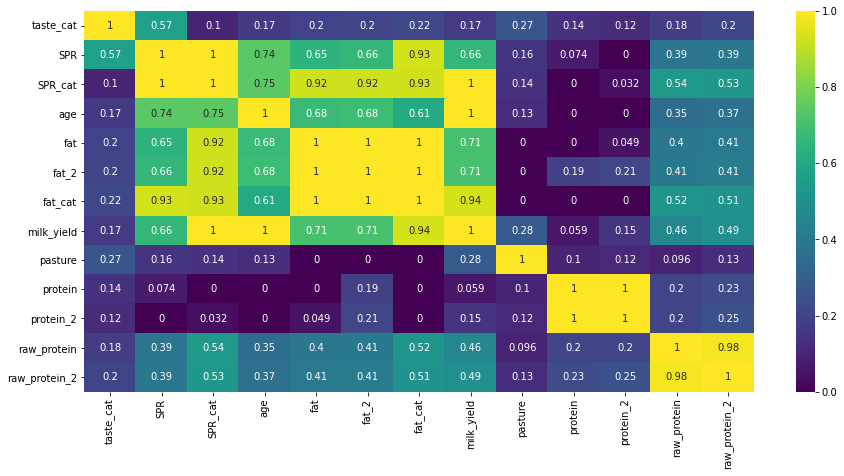

In [258]:
# Рассмотрим коэффициенты корреляции Фи с учетом новых признаков

fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(
    ferma_main[
        ['taste_cat', 'SPR', 'SPR_cat', 'age', 'fat', 'fat_2', 'fat_cat', 'milk_yield',\
         'pasture', 'protein', 'protein_2', 'raw_protein', 'raw_protein_2']
    ].phik_matrix(
    ), annot=True, cmap='viridis'
);

Исходя из матрицы корреляций наибольшее влияние на вкус оказывает фактор СПО. Меньшую роль играет ЭКЕ_2 и тип пастбища. И остальные признаки коррелируют в пределах от 0,12 до 0,2: возраст коровы, жирность молока и содержание белка в молоке, содержание белка в корме, и собственно количество молока.

In [259]:
ferma_main.columns.sort_values()

Index(['EFU', 'EFU_2', 'SPR', 'SPR_cat', 'age', 'breed', 'fat', 'fat_2',
       'fat_cat', 'father_breed', 'father_name', 'id', 'milk_yield', 'pasture',
       'protein', 'protein_2', 'raw_protein', 'raw_protein_2', 'taste',
       'taste_cat'],
      dtype='object')

In [260]:
# Отберем целевой и входящие признаки из выборки

X = ferma_main.drop(['taste', 'taste_cat'], axis=1)
y = ferma_main['taste_cat']

In [261]:
# Разобьем выборку на тренировочную и тестовую

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [262]:
# Создадим списки категориальных и количественных признаков

cat_col_names = ['age', 'pasture', 'breed', 'father_name']
num_col_names = ['EFU', 'raw_protein_2', 'protein_2', 'SPR_cat']

#'age', , 'raw_protein'   'SPR_cat', 'fat_2',

In [263]:
# Подготовим признаки для машинного обучения
# Кодирование

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

In [264]:
# Получение имен колонок

encoder_col_names = encoder.get_feature_names()

In [265]:
# Масштабирование данных

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [266]:
# Создание дата-фрейма с новыми данными

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [267]:
# Обучение модели и получение предсказаний на тестовых данных

clf = LogisticRegression()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [268]:
# Рассчитаем метрики модели
# Accuracy

acc = accuracy_score(y_test, y_pred)
acc

0.6305732484076433

Доля правильных ответов модели 66%, что крайне мало.

Рассмотрим далее меткири precision и recall.

In [269]:
# Precision

precision = precision_score(y_test, y_pred)
precision

0.6229508196721312

Класс 1 модель присваивает с точностью 64%. В целом точность не очень высокая.

In [270]:
# Recall

recall = recall_score(y_test, y_pred)
recall

0.8636363636363636

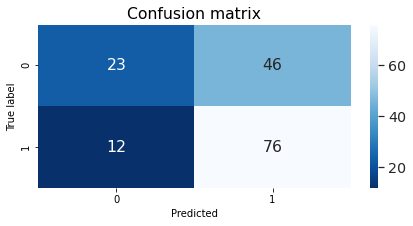

In [271]:
fig, ax = plt.subplots(figsize=(7, 3))
cm = confusion_matrix(y_test, y_pred)
sns.set (font_scale=1.3)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted');

Для фермера главное - вкусное молоко, значит precision должно быть максимальным.

Перейдем к регулированию порогового значения для присвоения класса.

In [272]:
# Создадим таблицу со значениями целевого признака из тестово выборки и предсказанным моделью

y_proba = clf.predict_proba(X_test)[:,1]
data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_test', 'y_proba']).sort_values(by='y_proba', ascending=False)

In [273]:
# Зададим диапазон порогов:

thresholds = [round(i, 2) for i in np.linspace(0.1, 1, num=45, endpoint=False)]
#thresholds

In [274]:
# Рассчитаем новые предсказания в соответствии с указанными порогами

columns = []

for i in thresholds:
    columns.append('y_pred_' + str(i))
    data['y_pred_' + str(i)] = data['y_proba'].apply(lambda y_1_proba: 1 if y_1_proba >= i else 0)

In [275]:
data.sample(5)

y_test   y_proba  y_pred_0.1  y_pred_0.12  y_pred_0.14  y_pred_0.16  \
11        1  0.769738           1            1            1            1   
73        0  0.494947           1            1            1            1   
93        0  0.452210           1            1            1            1   
148       0  0.609877           1            1            1            1   
54        0  0.788523           1            1            1            1   

     y_pred_0.18  y_pred_0.2  y_pred_0.22  y_pred_0.24  ...  y_pred_0.8  \
11             1           1            1            1  ...           0   
73             1           1            1            1  ...           0   
93             1           1            1            1  ...           0   
148            1           1            1            1  ...           0   
54             1           1            1            1  ...           0   

     y_pred_0.82  y_pred_0.84  y_pred_0.86  y_pred_0.88  y_pred_0.9  \
11             0            0            0            0           0   
73             0            0            0            0           0   
93             0            0            0            0           0   
148            0            0            0            0           0   
54             0            0            0            0           0   

     y_pred_0.92  y_pred_0.94  y_pred_0.96  y_pred_0.98  
11             0            0            0            0  
73             0            0            0            0  
93             0            0            0            0  
148            0            0            0            0  
54             0            0            0            0  

[5 rows x 47 columns]

In [276]:
# Сделаем сводную таблицу с суммой единичек в каждом столбце

df = data.pivot_table(index='y_test', aggfunc=('sum')).reset_index().T

In [277]:
# рассчиатем precision для каждого порога

df['precision'] = df[1] / (df[0] + df[1])
df.tail(15)

0          1  precision
y_pred_0.72   6.000000  30.000000   0.833333
y_pred_0.74   4.000000  24.000000   0.857143
y_pred_0.76   3.000000  19.000000   0.863636
y_pred_0.78   3.000000  12.000000   0.800000
y_pred_0.8    1.000000   7.000000   0.875000
y_pred_0.82   0.000000   4.000000   1.000000
y_pred_0.84   0.000000   3.000000   1.000000
y_pred_0.86   0.000000   0.000000        NaN
y_pred_0.88   0.000000   0.000000        NaN
y_pred_0.9    0.000000   0.000000        NaN
y_pred_0.92   0.000000   0.000000        NaN
y_pred_0.94   0.000000   0.000000        NaN
y_pred_0.96   0.000000   0.000000        NaN
y_pred_0.98   0.000000   0.000000        NaN
y_proba      38.209301  57.419829   0.600443

При пороге 0,82 модель будет присваивать класс 1 с 100% точностью.

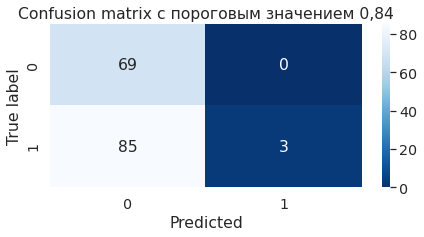

In [278]:
fig, ax = plt.subplots(figsize=(7, 3))
sns.set (font_scale=1.3)
cm = confusion_matrix(y_test, data['y_pred_0.84'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title("Confusion matrix с пороговым значением 0,84")
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Попробуем применить модель к нашим коровам

In [279]:
cow.columns

Index(['breed', 'pasture', 'father_breed', 'father_name', 'fat', 'protein',
       'age', 'EFU', 'raw_protein', 'SPR', 'EFU_2', 'SPR_cat', 'milk_yield'],
      dtype='object')

In [280]:
# Применим функцию

cow['fat_cat'] = cow.apply(fat_cat, axis=1)

In [281]:
# Добавим квадрат значений

cow['raw_protein_2'] = cow['raw_protein']**2
cow['protein_2'] = cow['protein']**2
cow['fat_2'] = cow['fat']**2

In [282]:
data_2 = cow

In [283]:
# Создадим списки категориальных и количественных признаков

cat_col_names = cat_col_names
num_col_names = num_col_names

In [284]:
# Подготовим признаки для машинного обучения
# Кодирование

data_2_ohe = encoder.transform(data_2[cat_col_names])

In [285]:
# Получение имен колонок

encoder_col_names = encoder.get_feature_names()

In [286]:
# Масштабирование данных

data_2_scaled = scaler.transform(data_2[num_col_names])

In [287]:
# Создание дата-фрейма с новыми данными

data_2_ohe = pd.DataFrame(data_2_ohe, columns=encoder_col_names)
data_2_scaled = pd.DataFrame(data_2_scaled, columns=num_col_names)
data_2 = pd.concat([data_2_ohe, data_2_scaled], axis=1)

In [288]:
# Создадим таблицу со значениями целевого признака из тестово выборки и предсказанным моделью

y_proba_data_2 = clf.predict_proba(data_2)[:,1]
data = pd.DataFrame(zip(y_proba_data_2), columns = ['y_proba_data_2'])

In [289]:
data['y_pred_new'] = data['y_proba_data_2'].apply(lambda y_proba_data_2: 'вкусно' if y_proba_data_2 > 0.84 else 'не вкусно')

In [290]:
# Добавим колонку с признаком ввкус молока в табличку с отобранными коровами

cow['taste'] = data['y_pred_new']

In [291]:
cow.query('taste == "вкусно"')

Empty DataFrame
Columns: [breed, pasture, father_breed, father_name, fat, protein, age, EFU, raw_protein, SPR, EFU_2, SPR_cat, milk_yield, fat_cat, raw_protein_2, protein_2, fat_2, taste]
Index: []

Получается, что ни одна из отобранной группы коров не подходит под критерии фермера.

**Вывод:**

Для обучения модели логистической регрессии признак вкус молока закодирован, как 1- вкусное. 0 - не вкусное.

Составлена матрица корреляции ФИ. Наибольшая зависимость с показателем вкус молока у СПО, затем ЭКЕ и тип пастбища. Покзатели породы коровы, породы папы-быка и мени папы-быка имеют со вкусом молока нулевую корреляцию и исключены из модели.

Составлена матрица корреляции при текущем пороге классификации. 
Рассчитаны 25 порогов классификации. Опимальное значение отобранных коров может быть достигнуто при пороге = 0,82. В этом случае ошибка 1 класса будет = 0 (Precision = 100%).

Исходя из этого значения проведен рассчет предсказаний вкуса молока для отобранных коров. 
Согласно предсказаниям модели, ни одна из отобранных коров не соответсвует критериям фермера.

## Итоговые выводы

In [292]:
cow.query('taste == "вкусно" and milk_yield >= 6000')

Empty DataFrame
Columns: [breed, pasture, father_breed, father_name, fat, protein, age, EFU, raw_protein, SPR, EFU_2, SPR_cat, milk_yield, fat_cat, raw_protein_2, protein_2, fat_2, taste]
Index: []

Из отобранной группы коров ни одна не соответствует ожиданиям фермера (удой больше 6000кг и вкусное молоко).

Рекомендовано: отобрать другую группу коров для прогнозирования признаков.

Необходимо учитывать, что более высокий удой отмечен у коров, происходящих от быка Буйный и Геркулес, от быков породы Айдиал. По типу пастбища - удой выше у коров, выпасаемых на холмистых пастбищах.

По вкусу молока основной фактор - СПО, стоит обратить на него внимание.